# Imports

In [1]:
import os
import random

from google.colab import drive
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix, completeness_score, homogeneity_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import umap.umap_ as umap


######################################
# SET SEED
######################################

RANDOM_STATE=0
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

ModuleNotFoundError: No module named 'hdbscan'

# Package Installations

In [ ]:
!pip install umap-learn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=a9088ba902a3f478c8f160c3fd72d99d2b9b5ef49a29ceb6e57c1becd9157107
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039284 sha256=a6a115b9753ed2d1bd5e8a69aa923dfc2a073d6ee2e14bbbb0bedfc8c0f72bd9
  S

# Setup

In [ ]:
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/courses/masters/winter 24/ece 219/project 2")
# os.chdir("/content/drive/MyDrive/ece 219/project 2")


from plotmat import plot_mat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Clustering with Sparse Text Representations

In [ ]:
########################
# FETCH DATA
########################

CATEGORIES = [
    "comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware", "rec.autos", "rec.motorcycles",
    "rec.sport.baseball", "rec.sport.hockey"
]

newsgroups = fetch_20newsgroups(subset="all", categories=CATEGORIES, remove=("headers", "footers"), random_state=RANDOM_STATE)
print (f"Size of news dataset: {len(newsgroups.data)}")

Size of news dataset: 7882


In [ ]:
########################
# PROCESS DATA
########################

cv = CountVectorizer(min_df=3, stop_words="english")

# Turn data into count vector
count_vector = cv.fit_transform(newsgroups.data)
print (f"Size of count vector: {count_vector.shape}")

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()
tfidf_counts = tfidf_transformer.fit_transform(count_vector)
print (f"Size of TF-IDF matrix: {tfidf_counts.shape}")

from scipy.sparse import csr_matrix

tfidf_counts_csr = csr_matrix(tfidf_counts)
non_zero_elements = tfidf_counts_csr.count_nonzero()
total_elements = tfidf_counts_csr.shape[0] * tfidf_counts_csr.shape[1]
proportion_non_zero = non_zero_elements / total_elements
print(f"Proportion of Non-Zero Elements: {proportion_non_zero:.4f}")

Size of count vector: (7882, 23522)
Size of TF-IDF matrix: (7882, 23522)
Proportion of Non-Zero Elements: 0.0028


In [ ]:
########################
# MANUALLY CLUSTER TARGETS
########################

y = []
for target in newsgroups.target:
  if target <= 3:
    y.append(0)
  else:
    y.append(1)

print (f"Size of target labels: {len(y)}")

Size of target labels: 7882


In [ ]:
########################
# KMeans CLUSTERING
########################

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, max_iter=1000, n_init=30)
kmeans.fit(tfidf_counts)

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

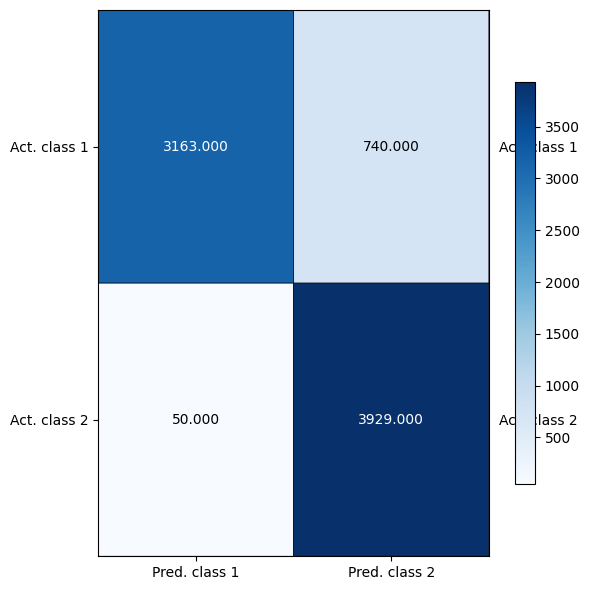

Homogeneity Score: 0.5791959247349042
Completeness Score: 0.5938590275126396
V-measure Score: 0.5864358322571914
Adjusted Rand Index Score: 0.6392240733134459
Adjusted Mutual Information score: 0.586397496683508
Average Scores: 0.5970224709003379


In [ ]:
########################
# KMeans CLUSTERING RESULTS
########################

conting_mat = contingency_matrix(y, kmeans.labels_)
plot_mat(conting_mat, size=(6, 6), xticklabels=["Pred. class 1", "Pred. class 2"], yticklabels=["Act. class 1", "Act. class 2"])

orig_hs = homogeneity_score(y, kmeans.labels_)
orig_cs = completeness_score(y, kmeans.labels_)
orig_vms = v_measure_score(y, kmeans.labels_)
orig_aris = adjusted_rand_score(y, kmeans.labels_)
orig_amis = adjusted_mutual_info_score(y, kmeans.labels_)

print (f"Homogeneity Score: {orig_hs}")
print (f"Completeness Score: {orig_cs}")
print (f"V-measure Score: {orig_vms}")
print (f"Adjusted Rand Index Score: {orig_aris}")
print (f"Adjusted Mutual Information score: {orig_amis}")
print (f"Average Scores: {(orig_hs + orig_cs + orig_vms + orig_aris + orig_amis) / 5}")

# Clustering with Dense Text Representations

In [ ]:
########################
# SVD REPRESENTATION
########################

def LSI(n_components, data):
  """Perform Latent Semantic Indexing, and calculate MSEs."""
  print (f"Performing LSI for {n_components} component(s)")

  svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)

  LSI_result = svd.fit_transform(data)
  print (f"LSI Train Data Shape: {LSI_result.shape}")

  return LSI_result, svd.explained_variance_ratio_

In [ ]:
########################
# PERFORM SVD
########################

# Compute explained variance ratio vs component number for LSI
n_components = 1000
_, explained_variance_ratio = LSI(n_components, tfidf_counts)

Performing LSI for 1000 component(s)
LSI Train Data Shape: (7882, 1000)


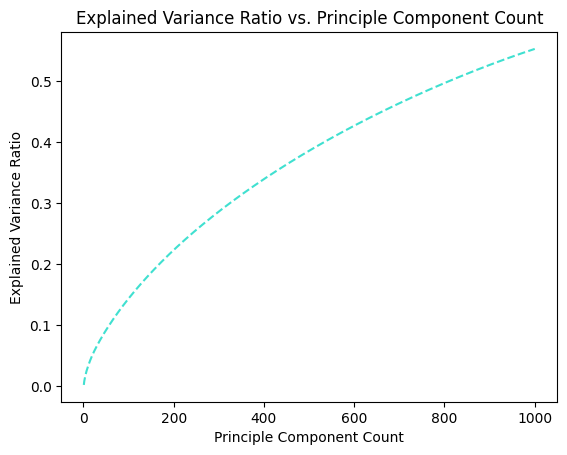

In [ ]:
########################
# PLOTTING SVD EVR
########################

evr_cumsum = np.cumsum(explained_variance_ratio)

x = [i for i in range(1, n_components+1)]

plt.plot(x, evr_cumsum, linestyle="--", color="turquoise")
plt.title("Explained Variance Ratio vs. Principle Component Count")
plt.xlabel("Principle Component Count")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [ ]:
########################
# NMF
########################

def perform_NMF(n_components, data):
  """Perform Non-negative Matrix Factorization, and calculate MSEs."""
  print (f"Performing NMF for {n_components} component(s)")

  # There might be a weird bug here where it says NMF() has an unexpected keyword argument "init"
  # I just had to rerun the first code block with the imports where I reinstalled sci-kit learn to update the version
  # This fixed it but it stopped working again later, so not sure if it will happen again
  nmf = NMF(n_components=n_components, init="random", random_state=RANDOM_STATE)

  NMF_result = nmf.fit_transform(data)
  print (f"NMF Train Data Shape: {NMF_result.shape}")

  return NMF_result

In [ ]:
########################
# SVD vs NMF
########################

n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

SVD_result, _ = LSI(max(n_components), tfidf_counts)
NMF_result = perform_NMF(max(n_components), tfidf_counts)

Performing LSI for 300 component(s)
LSI Train Data Shape: (7882, 300)
Performing NMF for 300 component(s)
NMF Train Data Shape: (7882, 300)


In [ ]:
########################
# SVD vs NMF MEASURE SCORES
########################

homogeneity_scores_SVD = []
completeness_scores_SVD = []
v_measure_scores_SVD = []
adjusted_rand_scores_SVD = []
adjusted_mutual_info_scores_SVD = []

homogeneity_scores_NMF = []
completeness_scores_NMF = []
v_measure_scores_NMF = []
adjusted_rand_scores_NMF = []
adjusted_mutual_info_scores_NMF = []

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, max_iter=1000, n_init=30)

for r in n_components:
  # Select top r components of results
  top_r_SVD, _ = LSI(r, tfidf_counts)
  top_r_NMF = perform_NMF(r, tfidf_counts)

  print (top_r_SVD.shape)
  print (top_r_NMF.shape)

  kmeans_svd = kmeans.fit(top_r_SVD)

  homogeneity_scores_SVD.append(homogeneity_score(y, kmeans_svd.labels_))
  completeness_scores_SVD.append(completeness_score(y, kmeans_svd.labels_))
  v_measure_scores_SVD.append(v_measure_score(y, kmeans_svd.labels_))
  adjusted_rand_scores_SVD.append(adjusted_rand_score(y, kmeans_svd.labels_))
  adjusted_mutual_info_scores_SVD.append(adjusted_mutual_info_score(y, kmeans_svd.labels_))

  kmeans_nmf = kmeans.fit(top_r_NMF)

  homogeneity_scores_NMF.append(homogeneity_score(y, kmeans_nmf.labels_))
  completeness_scores_NMF.append(completeness_score(y, kmeans_nmf.labels_))
  v_measure_scores_NMF.append(v_measure_score(y, kmeans_nmf.labels_))
  adjusted_rand_scores_NMF.append(adjusted_rand_score(y, kmeans_nmf.labels_))
  adjusted_mutual_info_scores_NMF.append(adjusted_mutual_info_score(y, kmeans_nmf.labels_))

Performing LSI for 1 component(s)
LSI Train Data Shape: (7882, 1)
Performing NMF for 1 component(s)
NMF Train Data Shape: (7882, 1)
(7882, 1)
(7882, 1)
Performing LSI for 2 component(s)
LSI Train Data Shape: (7882, 2)
Performing NMF for 2 component(s)
NMF Train Data Shape: (7882, 2)
(7882, 2)
(7882, 2)
Performing LSI for 3 component(s)
LSI Train Data Shape: (7882, 3)
Performing NMF for 3 component(s)
NMF Train Data Shape: (7882, 3)
(7882, 3)
(7882, 3)
Performing LSI for 4 component(s)
LSI Train Data Shape: (7882, 4)
Performing NMF for 4 component(s)
NMF Train Data Shape: (7882, 4)
(7882, 4)
(7882, 4)
Performing LSI for 5 component(s)
LSI Train Data Shape: (7882, 5)
Performing NMF for 5 component(s)
NMF Train Data Shape: (7882, 5)
(7882, 5)
(7882, 5)
Performing LSI for 6 component(s)
LSI Train Data Shape: (7882, 6)
Performing NMF for 6 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (7882, 6)
(7882, 6)
(7882, 6)
Performing LSI for 7 component(s)
LSI Train Data Shape: (7882, 7)
Performing NMF for 7 component(s)
NMF Train Data Shape: (7882, 7)
(7882, 7)
(7882, 7)
Performing LSI for 8 component(s)
LSI Train Data Shape: (7882, 8)
Performing NMF for 8 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (7882, 8)
(7882, 8)
(7882, 8)
Performing LSI for 9 component(s)
LSI Train Data Shape: (7882, 9)
Performing NMF for 9 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (7882, 9)
(7882, 9)
(7882, 9)
Performing LSI for 10 component(s)
LSI Train Data Shape: (7882, 10)
Performing NMF for 10 component(s)
NMF Train Data Shape: (7882, 10)
(7882, 10)
(7882, 10)
Performing LSI for 20 component(s)
LSI Train Data Shape: (7882, 20)
Performing NMF for 20 component(s)
NMF Train Data Shape: (7882, 20)
(7882, 20)
(7882, 20)
Performing LSI for 50 component(s)
LSI Train Data Shape: (7882, 50)
Performing NMF for 50 component(s)
NMF Train Data Shape: (7882, 50)
(7882, 50)
(7882, 50)
Performing LSI for 100 component(s)
LSI Train Data Shape: (7882, 100)
Performing NMF for 100 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (7882, 100)
(7882, 100)
(7882, 100)
Performing LSI for 300 component(s)
LSI Train Data Shape: (7882, 300)
Performing NMF for 300 component(s)
NMF Train Data Shape: (7882, 300)
(7882, 300)
(7882, 300)


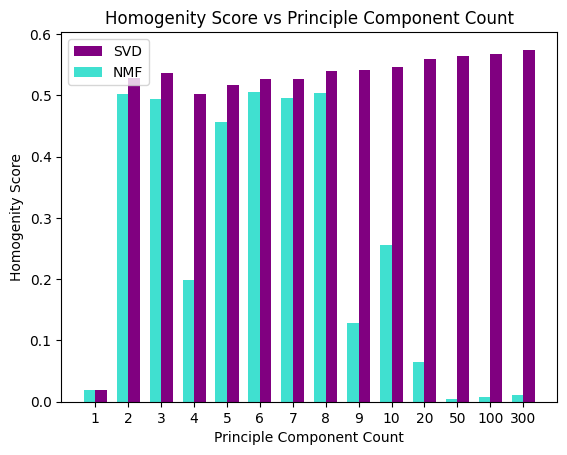

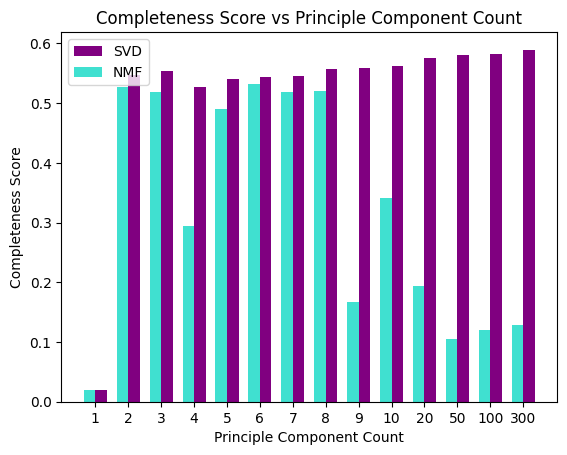

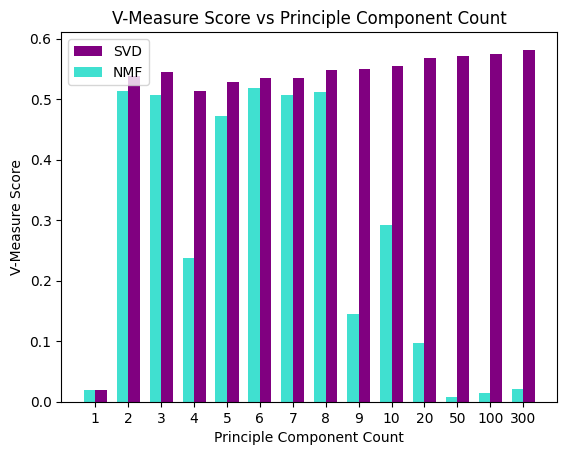

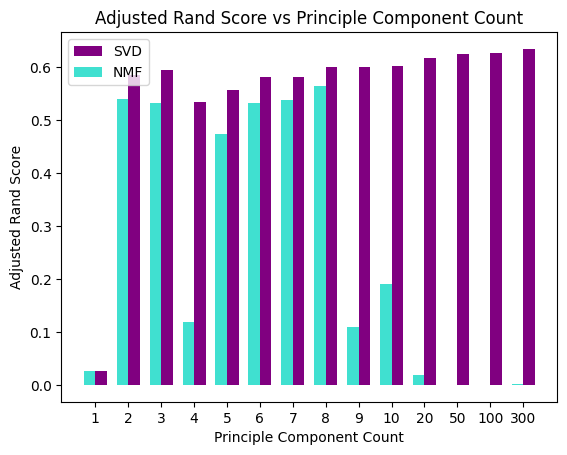

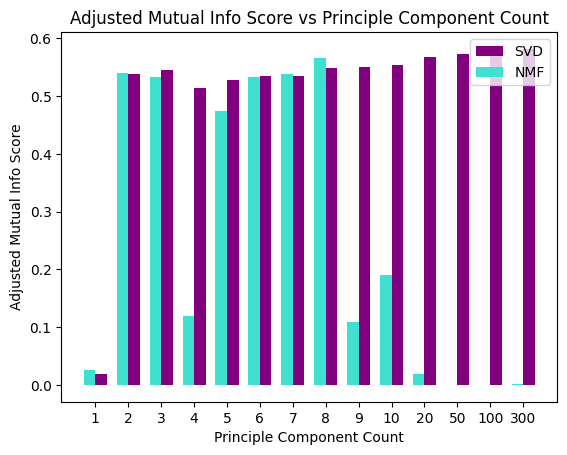

In [ ]:
########################
# PLOT MEASURE SCORES
########################

width = 0.35
fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) + width/2, homogeneity_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) - width/2, homogeneity_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Homogenity Score vs Principle Component Count")
ax.set_xlabel("Principle Component Count")
ax.set_ylabel("Homogenity Score")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) + width/2, completeness_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) - width/2, completeness_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Completeness Score vs Principle Component Count")
ax.set_xlabel("Principle Component Count")
ax.set_ylabel("Completeness Score")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) + width/2, v_measure_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) - width/2, v_measure_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("V-Measure Score vs Principle Component Count")
ax.set_xlabel("Principle Component Count")
ax.set_ylabel("V-Measure Score")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) + width/2, adjusted_rand_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) - width/2, adjusted_rand_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Adjusted Rand Score vs Principle Component Count")
ax.set_xlabel("Principle Component Count")
ax.set_ylabel("Adjusted Rand Score")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) + width/2, adjusted_mutual_info_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) - width/2, adjusted_rand_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Adjusted Mutual Info Score vs Principle Component Count")
ax.set_xlabel("Principle Component Count")
ax.set_ylabel("Adjusted Mutual Info Score")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

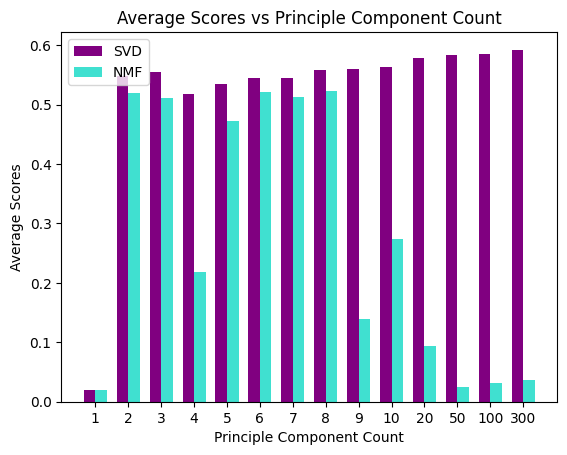

In [ ]:
########################
# BEST r VALUE
########################

average_scores_SVD = []
average_scores_NMF = []

for i in range(len(n_components)):
  hs_SVD = homogeneity_scores_SVD[i]
  cs_SVD = completeness_scores_SVD[i]
  vms_SVD = v_measure_scores_SVD[i]
  ars_SVD = adjusted_rand_scores_SVD[i]
  amis_SVD = adjusted_mutual_info_scores_SVD[i]

  avg_score_SVD = (hs_SVD + cs_SVD + vms_SVD + ars_SVD + amis_SVD) / 5
  average_scores_SVD.append(avg_score_SVD)

  hs_NMF = homogeneity_scores_NMF[i]
  cs_NMF = completeness_scores_NMF[i]
  vms_NMF = v_measure_scores_NMF[i]
  ars_NMF = adjusted_rand_scores_NMF[i]
  amis_NMF = adjusted_mutual_info_scores_NMF[i]

  avg_score_NMF = (hs_NMF + cs_NMF + vms_NMF + ars_NMF + amis_NMF) / 5
  average_scores_NMF.append(avg_score_NMF)

width = 0.35
fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) - width/2, average_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) + width/2, average_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Average Scores vs Principle Component Count")
ax.set_ylabel("Average Scores")
ax.set_xlabel("Principle Component Count")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

Best SVD score: 0.5923058485468932
Best NMF score: 0.5225456174266722
Performing LSI for 7 component(s)
LSI Train Data Shape: (7882, 7)


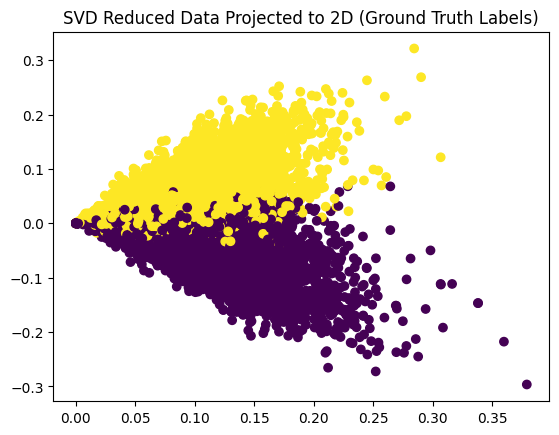

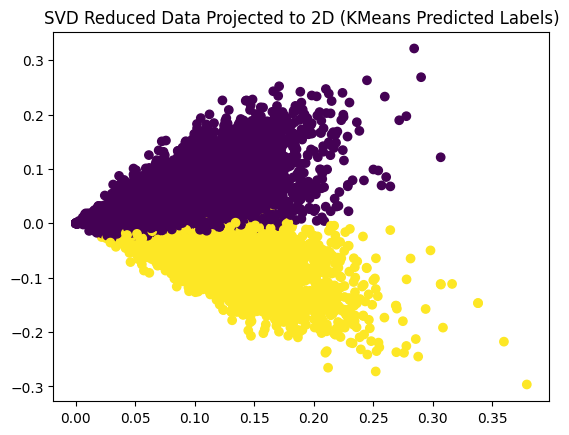

Performing NMF for 2 component(s)
NMF Train Data Shape: (7882, 2)


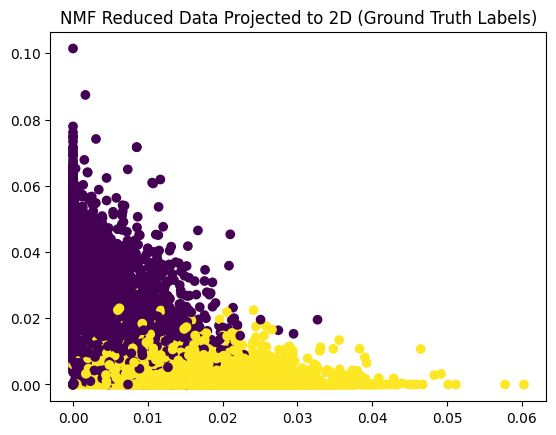

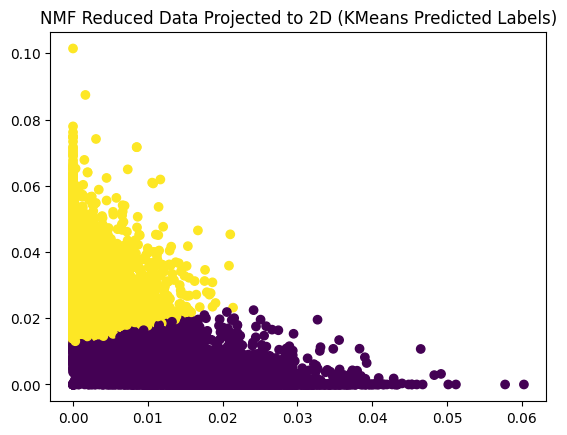

In [ ]:
########################
# CLUSTERING VISUALIZATION
########################

# Determine best r values
best_r_SVD = 7
best_r_SVD_score = average_scores_SVD[-1]

print (f"Best SVD score: {best_r_SVD_score}")

max_NMF_score = max(average_scores_NMF)
best_r_NMF = n_components[average_scores_NMF.index(max_NMF_score)]

print (f"Best NMF score: {max_NMF_score}")


# Begin plotting
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, max_iter=1000, n_init=30)

SVD_result, _ = LSI(best_r_SVD, tfidf_counts)
y_pred_SVD = kmeans.fit_predict(SVD_result)

plt.scatter(SVD_result[:, 0], SVD_result[:, 1], c=y)
plt.title("SVD Reduced Data Projected to 2D (Ground Truth Labels)")
plt.show()

plt.scatter(SVD_result[:, 0], SVD_result[:, 1], c=y_pred_SVD)
plt.title("SVD Reduced Data Projected to 2D (KMeans Predicted Labels)")
plt.show()

NMF_result = perform_NMF(2, tfidf_counts)
y_pred_NMF = kmeans.fit_predict(NMF_result)

plt.scatter(NMF_result[:, 0], NMF_result[:, 1], c=y)
plt.title("NMF Reduced Data Projected to 2D (Ground Truth Labels)")
plt.show()

plt.scatter(NMF_result[:, 0], NMF_result[:, 1], c=y_pred_NMF)
plt.title("NMF Reduced Data Projected to 2D (KMeans Predicted Labels)")
plt.show()

# Clustering (20 classes)

In [ ]:
########################
# FETCH ALL DATA
########################

newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers"), random_state=RANDOM_STATE)
print (f"Size of news dataset: {len(newsgroups.data)}")

Size of news dataset: 18846


In [ ]:
########################
# PROCESS NEW DATA
########################

cv = CountVectorizer(min_df=3, stop_words="english")

# Turn data into count vector
count_vector = cv.fit_transform(newsgroups.data)
print (f"Size of count vector: {count_vector.shape}")

# TF-IDF transformation
tfidf_transformer = TfidfTransformer()
tfidf_counts = tfidf_transformer.fit_transform(count_vector)
print (f"Size of TF-IDF matrix: {tfidf_counts.shape}")

Size of count vector: (18846, 45365)
Size of TF-IDF matrix: (18846, 45365)


In [ ]:
########################
# SVD vs NMF MEASURE SCORES, 20 CLUSTERS
########################

n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]

homogeneity_scores_SVD = []
completeness_scores_SVD = []
v_measure_scores_SVD = []
adjusted_rand_scores_SVD = []
adjusted_mutual_info_scores_SVD = []

homogeneity_scores_NMF = []
completeness_scores_NMF = []
v_measure_scores_NMF = []
adjusted_rand_scores_NMF = []
adjusted_mutual_info_scores_NMF = []

kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE, max_iter=1000, n_init=30)

for r in n_components:
  # Select top r components of results
  top_r_SVD, _ = LSI(r, tfidf_counts)
  top_r_NMF = perform_NMF(r, tfidf_counts)

  print (top_r_SVD.shape)
  print (top_r_NMF.shape)

  kmeans_svd = kmeans.fit(top_r_SVD)

  homogeneity_scores_SVD.append(homogeneity_score(newsgroups.target, kmeans_svd.labels_))
  completeness_scores_SVD.append(completeness_score(newsgroups.target, kmeans_svd.labels_))
  v_measure_scores_SVD.append(v_measure_score(newsgroups.target, kmeans_svd.labels_))
  adjusted_rand_scores_SVD.append(adjusted_rand_score(newsgroups.target, kmeans_svd.labels_))
  adjusted_mutual_info_scores_SVD.append(adjusted_mutual_info_score(newsgroups.target, kmeans_svd.labels_))

  kmeans_nmf = kmeans.fit(top_r_NMF)

  homogeneity_scores_NMF.append(homogeneity_score(newsgroups.target, kmeans_nmf.labels_))
  completeness_scores_NMF.append(completeness_score(newsgroups.target, kmeans_nmf.labels_))
  v_measure_scores_NMF.append(v_measure_score(newsgroups.target, kmeans_nmf.labels_))
  adjusted_rand_scores_NMF.append(adjusted_rand_score(newsgroups.target, kmeans_nmf.labels_))
  adjusted_mutual_info_scores_NMF.append(adjusted_mutual_info_score(newsgroups.target, kmeans_nmf.labels_))

Performing LSI for 1 component(s)
LSI Train Data Shape: (18846, 1)
Performing NMF for 1 component(s)
NMF Train Data Shape: (18846, 1)
(18846, 1)
(18846, 1)
Performing LSI for 2 component(s)
LSI Train Data Shape: (18846, 2)
Performing NMF for 2 component(s)
NMF Train Data Shape: (18846, 2)
(18846, 2)
(18846, 2)
Performing LSI for 3 component(s)
LSI Train Data Shape: (18846, 3)
Performing NMF for 3 component(s)
NMF Train Data Shape: (18846, 3)
(18846, 3)
(18846, 3)
Performing LSI for 4 component(s)
LSI Train Data Shape: (18846, 4)
Performing NMF for 4 component(s)
NMF Train Data Shape: (18846, 4)
(18846, 4)
(18846, 4)
Performing LSI for 5 component(s)
LSI Train Data Shape: (18846, 5)
Performing NMF for 5 component(s)
NMF Train Data Shape: (18846, 5)
(18846, 5)
(18846, 5)
Performing LSI for 6 component(s)
LSI Train Data Shape: (18846, 6)
Performing NMF for 6 component(s)
NMF Train Data Shape: (18846, 6)
(18846, 6)
(18846, 6)
Performing LSI for 7 component(s)
LSI Train Data Shape: (18846, 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (18846, 10)
(18846, 10)
(18846, 10)
Performing LSI for 20 component(s)
LSI Train Data Shape: (18846, 20)
Performing NMF for 20 component(s)
NMF Train Data Shape: (18846, 20)
(18846, 20)
(18846, 20)
Performing LSI for 50 component(s)
LSI Train Data Shape: (18846, 50)
Performing NMF for 50 component(s)
NMF Train Data Shape: (18846, 50)
(18846, 50)
(18846, 50)
Performing LSI for 100 component(s)
LSI Train Data Shape: (18846, 100)
Performing NMF for 100 component(s)
NMF Train Data Shape: (18846, 100)
(18846, 100)
(18846, 100)


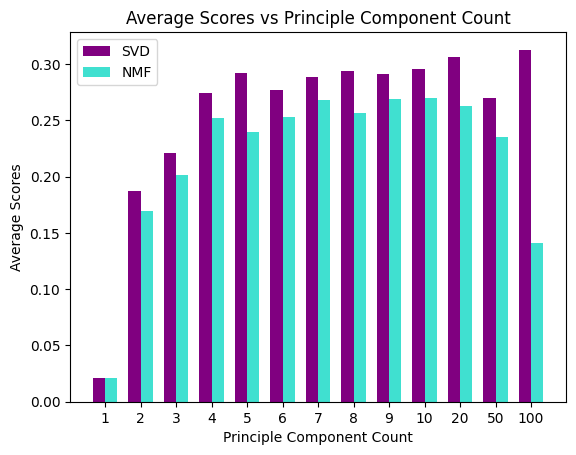

Best SVD score: 0.3128069316335742
Best NMF r: 10
Best NMF score: 0.26947221940458044


In [ ]:
########################
# BEST r VALUE
########################

average_scores_SVD = []
average_scores_NMF = []

for i in range(len(n_components)):
  hs_SVD = homogeneity_scores_SVD[i]
  cs_SVD = completeness_scores_SVD[i]
  vms_SVD = v_measure_scores_SVD[i]
  ars_SVD = adjusted_rand_scores_SVD[i]
  amis_SVD = adjusted_mutual_info_scores_SVD[i]

  avg_score_SVD = (hs_SVD + cs_SVD + vms_SVD + ars_SVD + amis_SVD) / 5
  average_scores_SVD.append(avg_score_SVD)

  hs_NMF = homogeneity_scores_NMF[i]
  cs_NMF = completeness_scores_NMF[i]
  vms_NMF = v_measure_scores_NMF[i]
  ars_NMF = adjusted_rand_scores_NMF[i]
  amis_NMF = adjusted_mutual_info_scores_NMF[i]

  avg_score_NMF = (hs_NMF + cs_NMF + vms_NMF + ars_NMF + amis_NMF) / 5
  average_scores_NMF.append(avg_score_NMF)

width = 0.35
fig, ax = plt.subplots()
ax.bar(np.arange(len(n_components)) - width/2, average_scores_SVD, width, label="SVD", color="purple")
ax.bar(np.arange(len(n_components)) + width/2, average_scores_NMF, width, label="NMF", color="turquoise")
ax.set_title("Average Scores vs Principle Component Count")
ax.set_ylabel("Average Scores")
ax.set_xlabel("Principle Component Count")
ax.set_xticks(np.arange(len(n_components)))
ax.set_xticklabels(n_components)
ax.legend()
plt.show()

# Determine best r values
best_r_SVD = 5
best_r_SVD_score = average_scores_SVD[-1]

print (f"Best SVD score: {best_r_SVD_score}")

max_NMF_score = max(average_scores_NMF)
best_r_NMF = n_components[average_scores_NMF.index(max_NMF_score)]

print (f"Best NMF r: {best_r_NMF}")
print (f"Best NMF score: {max_NMF_score}")

In [ ]:
########################
# RETRAIN ON BEST R
########################

kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE, max_iter=1000, n_init=30)

SVD_result, _ = LSI(best_r_SVD, tfidf_counts)
y_pred_SVD = kmeans.fit_predict(SVD_result)

hs_SVD = homogeneity_score(newsgroups.target, y_pred_SVD)
cs_SVD = completeness_score(newsgroups.target, y_pred_SVD)
vms_SVD = v_measure_score(newsgroups.target, y_pred_SVD)
ars_SVD = adjusted_rand_score(newsgroups.target, y_pred_SVD)
amis_SVD = adjusted_mutual_info_score(newsgroups.target, y_pred_SVD)

print (f"Homogeneity Score (SVD): {hs_SVD}")
print (f"Completeness Score (SVD): {cs_SVD}")
print (f"V-measure Score (SVD): {vms_SVD}")
print (f"Adjusted Rand Index Score (SVD): {ars_SVD}")
print (f"Adjusted Mutual Information score (SVD): {amis_SVD}")


NMF_result = perform_NMF(best_r_NMF, tfidf_counts)
y_pred_NMF = kmeans.fit_predict(NMF_result)

hs_NMF = homogeneity_score(newsgroups.target, y_pred_NMF)
cs_NMF = completeness_score(newsgroups.target, y_pred_NMF)
vms_NMF = v_measure_score(newsgroups.target, y_pred_NMF)
ars_NMF = adjusted_rand_score(newsgroups.target, y_pred_NMF)
amis_NMF = adjusted_mutual_info_score(newsgroups.target, y_pred_NMF)

print (f"Homogeneity Score (NMF): {hs_NMF}")
print (f"Completeness Score (NMF): {cs_NMF}")
print (f"V-measure Score (NMF): {vms_NMF}")
print (f"Adjusted Rand Index Score (NMF): {ars_NMF}")
print (f"Adjusted Mutual Information score (NMF): {amis_NMF}")

Performing LSI for 5 component(s)
LSI Train Data Shape: (18846, 5)
Homogeneity Score (SVD): 0.32016271714698474
Completeness Score (SVD): 0.3482890305417125
V-measure Score (SVD): 0.3336341411516645
Adjusted Rand Index Score (SVD): 0.1259875510824014
Adjusted Mutual Information score (SVD): 0.33138414757577583
Performing NMF for 10 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (18846, 10)
Homogeneity Score (NMF): 0.29544735896178187
Completeness Score (NMF): 0.3274814544666058
V-measure Score (NMF): 0.3106407305150111
Adjusted Rand Index Score (NMF): 0.10549913689715151
Adjusted Mutual Information score (NMF): 0.30829241618235176


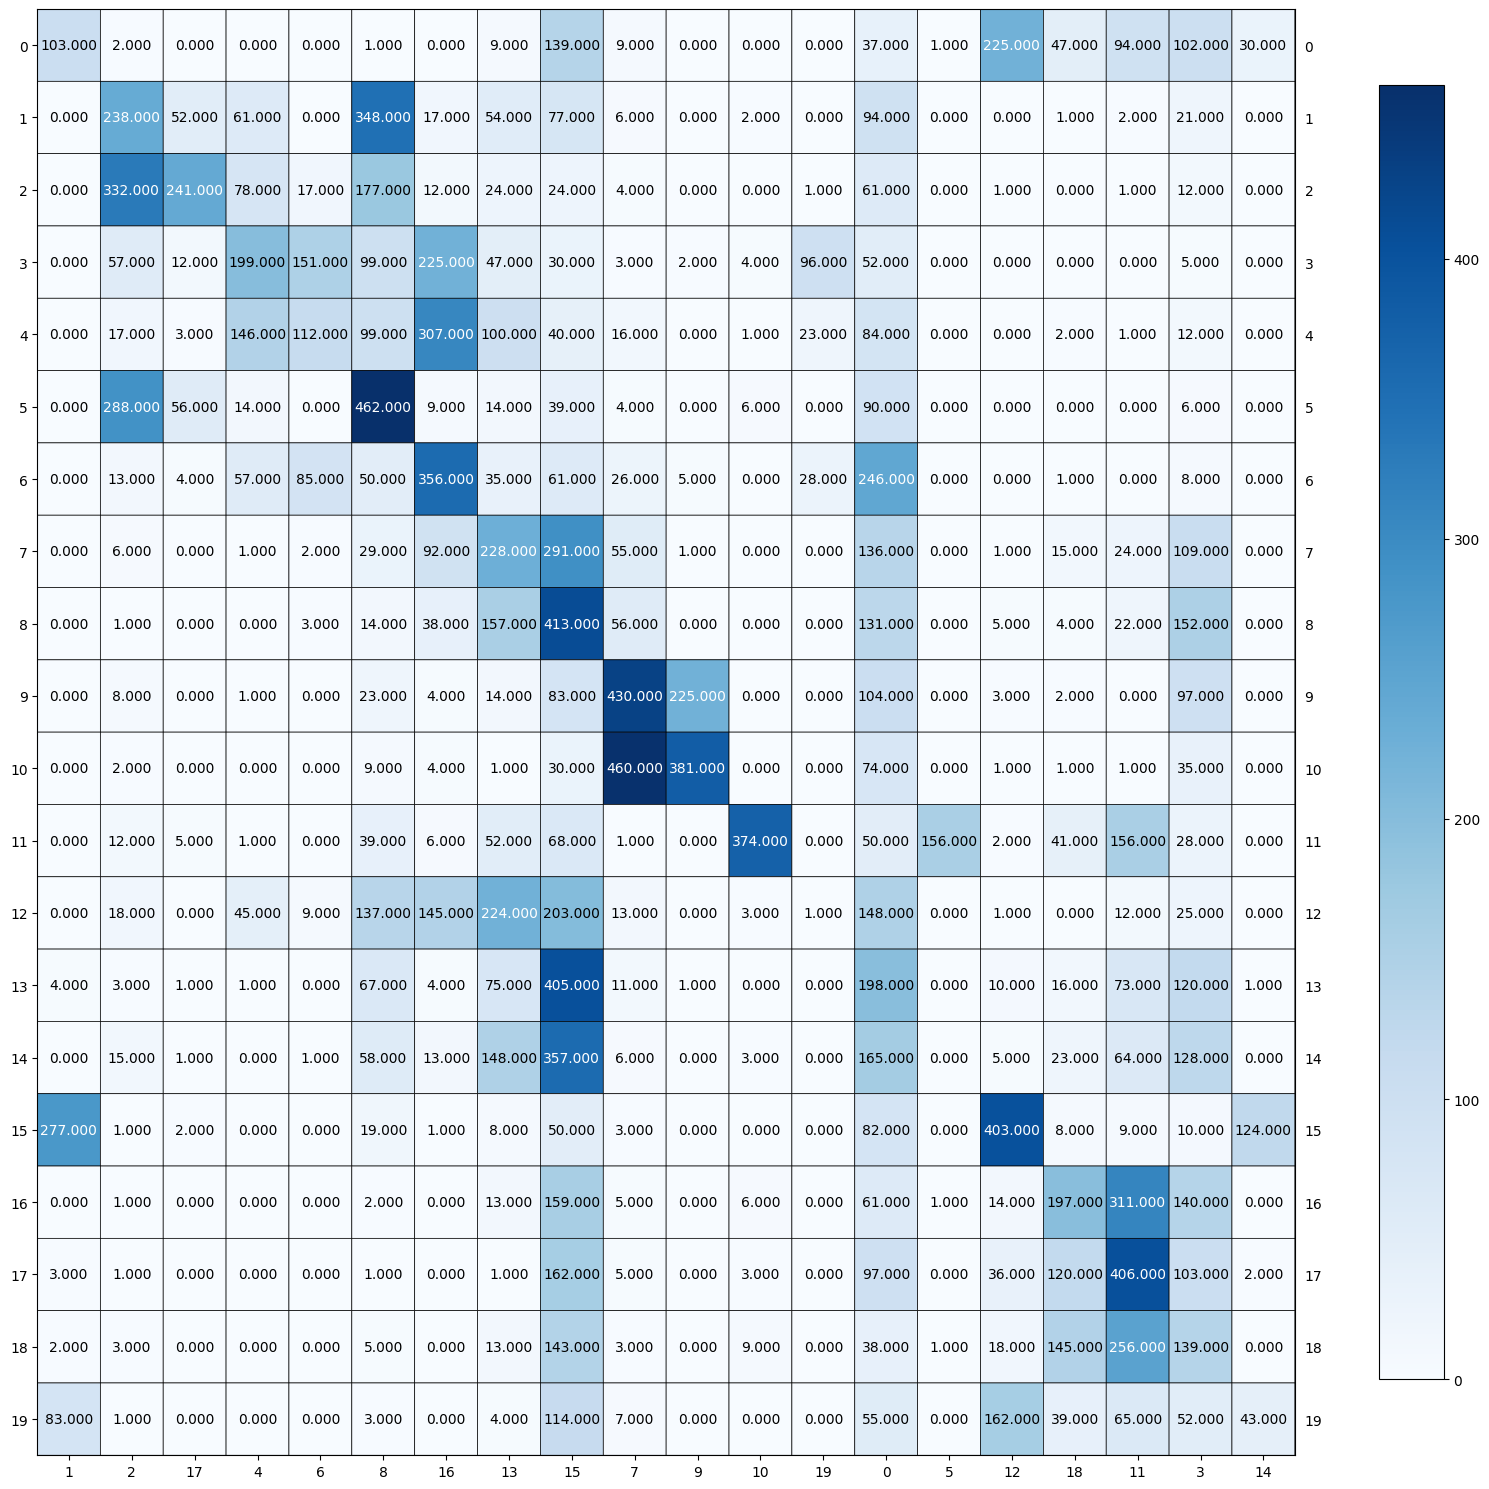

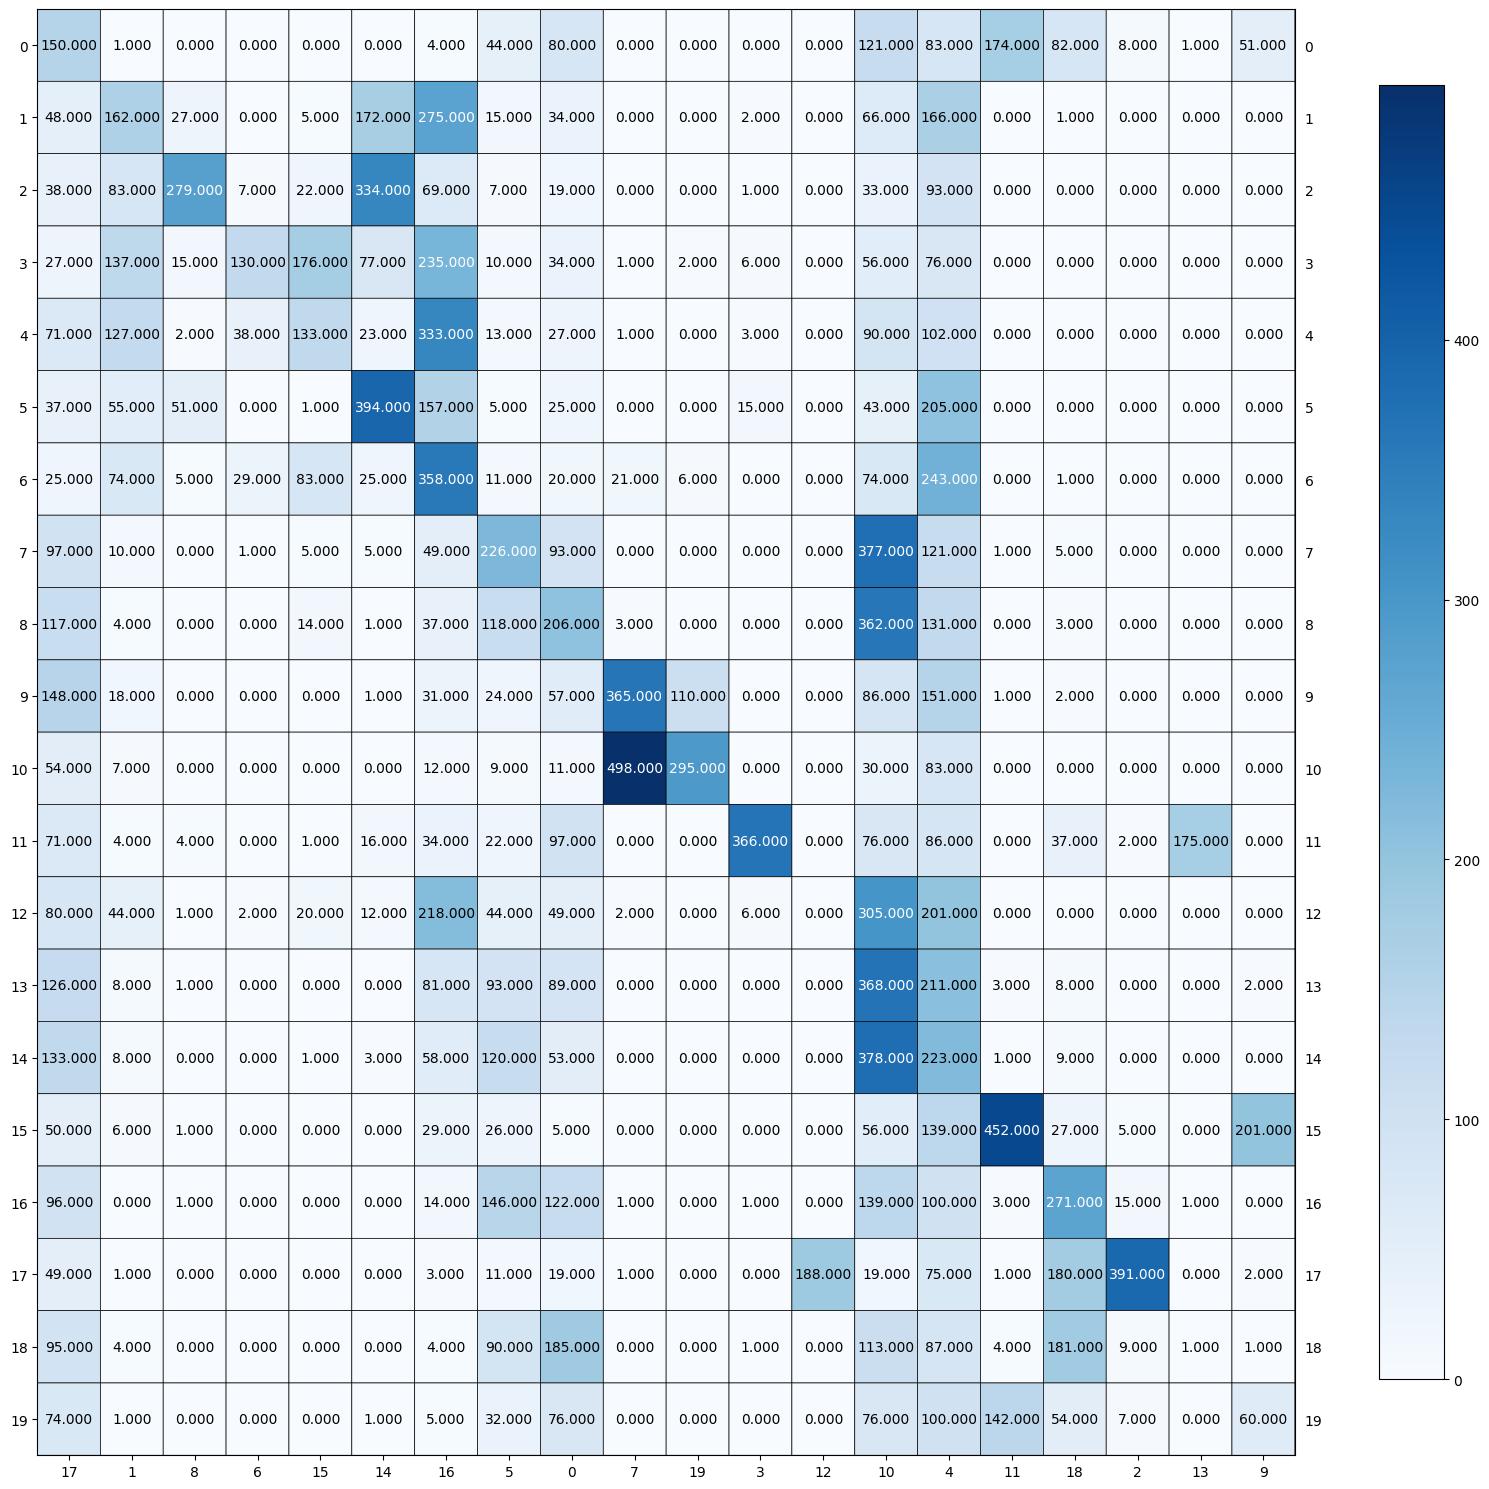

In [ ]:
########################
# PLOT CONFUSION MATRICES
########################

cm = confusion_matrix(newsgroups.target, y_pred_SVD)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15, 15))

cm = confusion_matrix(newsgroups.target, y_pred_NMF)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15, 15))

# UMAP Dimensionality Reduction

In [ ]:
def perform_UMAP(data, metric, n_components):
  reducer = umap.UMAP(n_components=n_components, metric=metric, random_state=RANDOM_STATE)
  UMAP_result = reducer.fit_transform(data)
  return UMAP_result

In [ ]:
########################
# UMAP REDUCTION
########################

# Each array will be length of len(n_components)
# Each element is a 2-tuple, first element of tuple is "cosine" metric score,
# second is "euclidian" metric score
homogeneity_scores_UMAP = []
completeness_scores_UMAP = []
v_measure_scores_UMAP = []
adjusted_rand_scores_UMAP = []
adjusted_mutual_info_scores_UMAP = []

predicted_labels = []

kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE, max_iter=1000, n_init=30)

n_components = [5, 20, 200]
metrics = ["cosine", "euclidean"]
for r in n_components:
  top_r_UMAP_0 = perform_UMAP(tfidf_counts, metrics[0], r)
  y_UMAP_0 = kmeans.fit_predict(top_r_UMAP_0)

  top_r_UMAP_1 = perform_UMAP(tfidf_counts, metrics[1], r)
  y_UMAP_1 = kmeans.fit_predict(top_r_UMAP_1)

  predicted_labels.append((y_UMAP_0, y_UMAP_1))

  hs_0 = homogeneity_score(newsgroups.target, y_UMAP_0)
  hs_1 = homogeneity_score(newsgroups.target, y_UMAP_1)

  cs_0 = completeness_score(newsgroups.target, y_UMAP_0)
  cs_1 = completeness_score(newsgroups.target, y_UMAP_1)

  vms_0 = v_measure_score(newsgroups.target, y_UMAP_0)
  vms_1 = v_measure_score(newsgroups.target, y_UMAP_1)

  ars_0 = adjusted_rand_score(newsgroups.target, y_UMAP_0)
  ars_1 = adjusted_rand_score(newsgroups.target, y_UMAP_1)

  amis_0 = adjusted_mutual_info_score(newsgroups.target, y_UMAP_0)
  amis_1 = adjusted_mutual_info_score(newsgroups.target, y_UMAP_1)

  homogeneity_scores_UMAP.append((hs_0, hs_1))
  completeness_scores_UMAP.append((cs_0, cs_1))
  v_measure_scores_UMAP.append((vms_0, vms_1))
  adjusted_rand_scores_UMAP.append((ars_0, ars_1))
  adjusted_mutual_info_scores_UMAP.append((amis_0, amis_1))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} over

In [ ]:
########################
# DISPLAY SCORES
########################

for i, r in enumerate(n_components):
  print (f"Homogeneity Score (Cosine, {r} components): {homogeneity_scores_UMAP[i][0]}")
  print (f"Completeness Score (Cosine, {r} components): {completeness_scores_UMAP[i][0]}")
  print (f"V-Measure Score (Cosine, {r} components): {v_measure_scores_UMAP[i][0]}")
  print (f"Adjusted Rand Score (Cosine, {r} components): {adjusted_rand_scores_UMAP[i][0]}")
  print (f"Adjusted Mutual Info Score (Cosine, {r} components): {adjusted_mutual_info_scores_UMAP[i][0]}")
  print (f"Average Score (Cosine, {r} components): {(homogeneity_scores_UMAP[i][0] + completeness_scores_UMAP[i][0] + v_measure_scores_UMAP[i][0] + adjusted_rand_scores_UMAP[i][0] + adjusted_mutual_info_scores_UMAP[i][0]) / 5}")

  print ("\n")

  print (f"Homogeneity Score (Euclidean, {r} components): {homogeneity_scores_UMAP[i][1]}")
  print (f"Completeness Score (Euclidean, {r} components): {completeness_scores_UMAP[i][1]}")
  print (f"V-Measure Score (Euclidean, {r} components): {v_measure_scores_UMAP[i][1]}")
  print (f"Adjusted Rand Score (Euclidean, {r} components): {adjusted_rand_scores_UMAP[i][1]}")
  print (f"Adjusted Mutual Info Score (Euclidean, {r} components): {adjusted_mutual_info_scores_UMAP[i][1]}")
  print (f"Average Score (Euclidean, {r} components): {(homogeneity_scores_UMAP[i][1] + completeness_scores_UMAP[i][1] + v_measure_scores_UMAP[i][1] + adjusted_rand_scores_UMAP[i][1] + adjusted_mutual_info_scores_UMAP[i][1]) / 5}")

  print ("\n")

Homogeneity Score (Cosine, 5 components): 0.5757393786334769
Completeness Score (Cosine, 5 components): 0.596170314940667
V-Measure Score (Cosine, 5 components): 0.5857767515120362
Adjusted Rand Score (Cosine, 5 components): 0.460359263242143
Adjusted Mutual Info Score (Cosine, 5 components): 0.584404126405671
Average Score (Cosine, 5 components): 0.5604899669467989


Homogeneity Score (Euclidean, 5 components): 0.006478555842729128
Completeness Score (Euclidean, 5 components): 0.006517670097977768
V-Measure Score (Euclidean, 5 components): 0.006498054109997733
Adjusted Rand Score (Euclidean, 5 components): 0.001264960852663542
Adjusted Mutual Info Score (Euclidean, 5 components): 0.003282579427816658
Average Score (Euclidean, 5 components): 0.004808364066236966


Homogeneity Score (Cosine, 20 components): 0.5731621212431922
Completeness Score (Cosine, 20 components): 0.5953023492883153
V-Measure Score (Cosine, 20 components): 0.5840224771985414
Adjusted Rand Score (Cosine, 20 componen

In [ ]:
########################
# PLOT CONTINGENCY MATRICES
########################

for i, (y_UMAP_cos, y_UMAP_euclid) in enumerate(predicted_labels):
  cm = confusion_matrix(newsgroups.target, y_UMAP_cos)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title=f"UMAP-reduced Data (Cosine, r = {n_components[i]})", size=(15, 13))

  cm = confusion_matrix(newsgroups.target, y_UMAP_euclid)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title=f"UMAP-reduced Data (Euclidean, r = {n_components[i]})", size=(15, 13))

Output hidden; open in https://colab.research.google.com to view.

# Final 20 Class Dim-Red + Clustering

In [ ]:
########################
# DIMENSIONALITY REDUCTION
########################

n_components = [5, 20, 200]

SVD_results = []
NMF_results = []
UMAP_results = []
for r in n_components:
  SVD_result, _ = LSI(r, tfidf_counts)
  NMF_result = perform_NMF(r, tfidf_counts)
  UMAP_result = perform_UMAP(tfidf_counts, "cosine", r)

  SVD_results.append(SVD_result)
  NMF_results.append(NMF_result)
  UMAP_results.append(UMAP_result)

Performing LSI for 5 component(s)
LSI Train Data Shape: (18846, 5)
Performing NMF for 5 component(s)
NMF Train Data Shape: (18846, 5)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Performing LSI for 20 component(s)
LSI Train Data Shape: (18846, 20)
Performing NMF for 20 component(s)
NMF Train Data Shape: (18846, 20)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Performing LSI for 200 component(s)
LSI Train Data Shape: (18846, 200)
Performing NMF for 200 component(s)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Train Data Shape: (18846, 200)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
########################
# KMEANS CLUSTERING
########################

clusters = [10, 20, 50]
for cluster in clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=RANDOM_STATE, max_iter=1000, n_init=30)
  y_pred_ORIG = kmeans.fit_predict(tfidf_counts)

  hs_ORIG = homogeneity_score(newsgroups.target, y_pred_ORIG)
  cs_ORIG = completeness_score(newsgroups.target, y_pred_ORIG)
  vms_ORIG = v_measure_score(newsgroups.target, y_pred_ORIG)
  ars_ORIG = adjusted_rand_score(newsgroups.target, y_pred_ORIG)
  amis_ORIG = adjusted_mutual_info_score(newsgroups.target, y_pred_ORIG)
  average_score_ORIG = (hs_ORIG + cs_ORIG + vms_ORIG + ars_ORIG + amis_ORIG) / 5

  print (f"Average Score [Unreduced] [KMeans, k = {cluster}]: {average_score_ORIG}")

  for i, SVD_result in enumerate(SVD_results):
    y_pred_SVD = kmeans.fit_predict(SVD_result)

    hs_SVD = homogeneity_score(newsgroups.target, y_pred_SVD)
    cs_SVD = completeness_score(newsgroups.target, y_pred_SVD)
    vms_SVD = v_measure_score(newsgroups.target, y_pred_SVD)
    ars_SVD = adjusted_rand_score(newsgroups.target, y_pred_SVD)
    amis_SVD = adjusted_mutual_info_score(newsgroups.target, y_pred_SVD)
    average_score_SVD = (hs_SVD + cs_SVD + vms_SVD + ars_SVD + amis_SVD) / 5

    print (f"Average Score [SVD, r = {n_components[i]}] [KMeans, k = {cluster}]: {average_score_SVD}")

  for i, NMF_result in enumerate(NMF_results):
    y_pred_NMF = kmeans.fit_predict(NMF_result)

    hs_NMF = homogeneity_score(newsgroups.target, y_pred_NMF)
    cs_NMF = completeness_score(newsgroups.target, y_pred_NMF)
    vms_NMF = v_measure_score(newsgroups.target, y_pred_NMF)
    ars_NMF = adjusted_rand_score(newsgroups.target, y_pred_NMF)
    amis_NMF = adjusted_mutual_info_score(newsgroups.target, y_pred_NMF)
    average_score_NMF = (hs_NMF + cs_NMF + vms_NMF + ars_NMF + amis_NMF) / 5

    print (f"Average Score [NMF, r = {n_components[i]}] [KMeans, k = {cluster}]: {average_score_NMF}")

  for i, UMAP_result in enumerate(UMAP_results):
    y_pred_UMAP = kmeans.fit_predict(UMAP_result)

    hs_UMAP = homogeneity_score(newsgroups.target, y_pred_UMAP)
    cs_UMAP = completeness_score(newsgroups.target, y_pred_UMAP)
    vms_UMAP = v_measure_score(newsgroups.target, y_pred_UMAP)
    ars_UMAP = adjusted_rand_score(newsgroups.target, y_pred_UMAP)
    amis_UMAP = adjusted_mutual_info_score(newsgroups.target, y_pred_UMAP)
    average_score_UMAP = (hs_UMAP + cs_UMAP + vms_UMAP + ars_UMAP + amis_UMAP) / 5

    print (f"Average Score [UMAP, r = {n_components[i]}] [KMeans, k = {cluster}]: {average_score_UMAP}")

Average Score [Unreduced] [KMeans, k = 10]: 0.3127298558065917
Average Score [SVD, r = 5] [KMeans, k = 10]: 0.28826121545814104
Average Score [SVD, r = 20] [KMeans, k = 10]: 0.28103632815154544
Average Score [SVD, r = 200] [KMeans, k = 10]: 0.27397170620866157
Average Score [NMF, r = 5] [KMeans, k = 10]: 0.24105909324884447
Average Score [NMF, r = 20] [KMeans, k = 10]: 0.21331247059166847
Average Score [NMF, r = 200] [KMeans, k = 10]: 0.032385718417162965
Average Score [UMAP, r = 5] [KMeans, k = 10]: 0.5001602918761598
Average Score [UMAP, r = 20] [KMeans, k = 10]: 0.501103386927099
Average Score [UMAP, r = 200] [KMeans, k = 10]: 0.4998333858310423
Average Score [Unreduced] [KMeans, k = 20]: 0.3037430666748485
Average Score [SVD, r = 5] [KMeans, k = 20]: 0.2918915174997078
Average Score [SVD, r = 20] [KMeans, k = 20]: 0.3065475948781547
Average Score [SVD, r = 200] [KMeans, k = 20]: 0.32461349858546773
Average Score [NMF, r = 5] [KMeans, k = 20]: 0.2396382853881612
Average Score [NMF, 

In [ ]:
########################
# AGGLOMERATIVE CLUSTERING
########################

clusters = [20]
for cluster in clusters:
  ac = AgglomerativeClustering(n_clusters=cluster, linkage="ward")
  # y_pred_ORIG = ac.fit_predict(tfidf_counts)

  # hs_ORIG = homogeneity_score(newsgroups.target, y_pred_ORIG)
  # cs_ORIG = completeness_score(newsgroups.target, y_pred_ORIG)
  # vms_ORIG = v_measure_score(newsgroups.target, y_pred_ORIG)
  # ars_ORIG = adjusted_rand_score(newsgroups.target, y_pred_ORIG)
  # amis_ORIG = adjusted_mutual_info_score(newsgroups.target, y_pred_ORIG)
  # average_score_ORIG = (hs_ORIG + cs_ORIG + vms_ORIG + ars_ORIG + amis_ORIG) / 5

  print (f"Average Score [Unreduced] [Agglomerative Clustering, k = {cluster}]: N/A, sparse matrices not allowed")

  for i, SVD_result in enumerate(SVD_results):
    y_pred_SVD = ac.fit_predict(SVD_result)

    hs_SVD = homogeneity_score(newsgroups.target, y_pred_SVD)
    cs_SVD = completeness_score(newsgroups.target, y_pred_SVD)
    vms_SVD = v_measure_score(newsgroups.target, y_pred_SVD)
    ars_SVD = adjusted_rand_score(newsgroups.target, y_pred_SVD)
    amis_SVD = adjusted_mutual_info_score(newsgroups.target, y_pred_SVD)
    average_score_SVD = (hs_SVD + cs_SVD + vms_SVD + ars_SVD + amis_SVD) / 5

    print (f"Average Score [SVD, r = {n_components[i]}] [Agglomerative Clustering, k = {cluster}]: {average_score_SVD}")

  for i, NMF_result in enumerate(NMF_results):
    y_pred_NMF = ac.fit_predict(NMF_result)

    hs_NMF = homogeneity_score(newsgroups.target, y_pred_NMF)
    cs_NMF = completeness_score(newsgroups.target, y_pred_NMF)
    vms_NMF = v_measure_score(newsgroups.target, y_pred_NMF)
    ars_NMF = adjusted_rand_score(newsgroups.target, y_pred_NMF)
    amis_NMF = adjusted_mutual_info_score(newsgroups.target, y_pred_NMF)
    average_score_NMF = (hs_NMF + cs_NMF + vms_NMF + ars_NMF + amis_NMF) / 5

    print (f"Average Score [NMF, r = {n_components[i]}] [Agglomerative Clustering, k = {cluster}]: {average_score_NMF}")

  for i, UMAP_result in enumerate(UMAP_results):
    y_pred_UMAP = ac.fit_predict(UMAP_result)

    hs_UMAP = homogeneity_score(newsgroups.target, y_pred_UMAP)
    cs_UMAP = completeness_score(newsgroups.target, y_pred_UMAP)
    vms_UMAP = v_measure_score(newsgroups.target, y_pred_UMAP)
    ars_UMAP = adjusted_rand_score(newsgroups.target, y_pred_UMAP)
    amis_UMAP = adjusted_mutual_info_score(newsgroups.target, y_pred_UMAP)
    average_score_UMAP = (hs_UMAP + cs_UMAP + vms_UMAP + ars_UMAP + amis_UMAP) / 5

    print (f"Average Score [UMAP, r = {n_components[i]}] [Agglomerative Clustering, k = {cluster}]: {average_score_UMAP}")

Average Score [Unreduced] [Agglomerative Clustering, k = 20]: N/A, sparse matrices not allowed


NameError: name 'SVD_results' is not defined

In [ ]:
########################
# HDBSCAN
########################

min_cluster_sizes = [100, 200]
for mcs in min_cluster_sizes:
  hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs)
  # y_pred_ORIG = hdbs.fit_predict(tfidf_counts)

  # hs_ORIG = homogeneity_score(newsgroups.target, y_pred_ORIG)
  # cs_ORIG = completeness_score(newsgroups.target, y_pred_ORIG)
  # vms_ORIG = v_measure_score(newsgroups.target, y_pred_ORIG)
  # ars_ORIG = adjusted_rand_score(newsgroups.target, y_pred_ORIG)
  # amis_ORIG = adjusted_mutual_info_score(newsgroups.target, y_pred_ORIG)
  # average_score_ORIG = (hs_ORIG + cs_ORIG + vms_ORIG + ars_ORIG + amis_ORIG) / 5

  print (f"Average Score [Unreduced] [HDBSCAN, mcs = {mcs}]: N/A, not enough memory")

  for i, SVD_result in enumerate(SVD_results):
    y_pred_SVD = hdbs.fit_predict(SVD_result)

    hs_SVD = homogeneity_score(newsgroups.target, y_pred_SVD)
    cs_SVD = completeness_score(newsgroups.target, y_pred_SVD)
    vms_SVD = v_measure_score(newsgroups.target, y_pred_SVD)
    ars_SVD = adjusted_rand_score(newsgroups.target, y_pred_SVD)
    amis_SVD = adjusted_mutual_info_score(newsgroups.target, y_pred_SVD)
    average_score_SVD = (hs_SVD + cs_SVD + vms_SVD + ars_SVD + amis_SVD) / 5

    print (f"Average Score [SVD, r = {n_components[i]}] [HDBSCAN, mcs = {mcs}]: {average_score_SVD}")

  for i, NMF_result in enumerate(NMF_results):
    y_pred_NMF = hdbs.fit_predict(NMF_result)

    hs_NMF = homogeneity_score(newsgroups.target, y_pred_NMF)
    cs_NMF = completeness_score(newsgroups.target, y_pred_NMF)
    vms_NMF = v_measure_score(newsgroups.target, y_pred_NMF)
    ars_NMF = adjusted_rand_score(newsgroups.target, y_pred_NMF)
    amis_NMF = adjusted_mutual_info_score(newsgroups.target, y_pred_NMF)
    average_score_NMF = (hs_NMF + cs_NMF + vms_NMF + ars_NMF + amis_NMF) / 5

    print (f"Average Score [NMF, r = {n_components[i]}] [HDBSCAN, mcs = {mcs}]: {average_score_NMF}")

  for i, UMAP_result in enumerate(UMAP_results):
    y_pred_UMAP = hdbs.fit_predict(UMAP_result)

    hs_UMAP = homogeneity_score(newsgroups.target, y_pred_UMAP)
    cs_UMAP = completeness_score(newsgroups.target, y_pred_UMAP)
    vms_UMAP = v_measure_score(newsgroups.target, y_pred_UMAP)
    ars_UMAP = adjusted_rand_score(newsgroups.target, y_pred_UMAP)
    amis_UMAP = adjusted_mutual_info_score(newsgroups.target, y_pred_UMAP)
    average_score_UMAP = (hs_UMAP + cs_UMAP + vms_UMAP + ars_UMAP + amis_UMAP) / 5

    print (f"Average Score [UMAP, r = {n_components[i]}] [HDBSCAN, mcs = {mcs}]: {average_score_UMAP}")

Average Score [Unreduced] [HDBSCAN, mcs = 100]: N/A, not enough memory
Average Score [SVD, r = 5] [HDBSCAN, mcs = 100]: 0.2
Average Score [SVD, r = 20] [HDBSCAN, mcs = 100]: 0.2
Average Score [SVD, r = 200] [HDBSCAN, mcs = 100]: 0.2
Average Score [NMF, r = 5] [HDBSCAN, mcs = 100]: 0.1067468991884675
Average Score [NMF, r = 20] [HDBSCAN, mcs = 100]: 0.2
Average Score [NMF, r = 200] [HDBSCAN, mcs = 100]: 0.2
Average Score [UMAP, r = 5] [HDBSCAN, mcs = 100]: 0.4537056725753077
Average Score [UMAP, r = 20] [HDBSCAN, mcs = 100]: 0.4516924983408176
Average Score [UMAP, r = 200] [HDBSCAN, mcs = 100]: 0.4391426102513131
Average Score [Unreduced] [HDBSCAN, mcs = 200]: N/A, not enough memory
Average Score [SVD, r = 5] [HDBSCAN, mcs = 200]: 0.2
Average Score [SVD, r = 20] [HDBSCAN, mcs = 200]: 0.2
Average Score [SVD, r = 200] [HDBSCAN, mcs = 200]: 0.2
Average Score [NMF, r = 5] [HDBSCAN, mcs = 200]: 0.048623498974678075
Average Score [NMF, r = 20] [HDBSCAN, mcs = 200]: 0.2
Average Score [NMF, r =

# Non-Gaussian Clustering

In [ ]:
########################
# AGGLOMERATIVE CLUSTERING
########################

UMAP_result = perform_UMAP(tfidf_counts, "cosine", 5)

ac_ward = AgglomerativeClustering(n_clusters=20, linkage="ward")
y_pred_ac_ward = ac_ward.fit_predict(UMAP_result)

ac_single = AgglomerativeClustering(n_clusters=20, linkage="single")
y_pred_ac_single = ac_single.fit_predict(UMAP_result)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
########################
# SCORES
########################

hs_ward = homogeneity_score(newsgroups.target, y_pred_ac_ward)
hs_single = homogeneity_score(newsgroups.target, y_pred_ac_single)

cs_ward = completeness_score(newsgroups.target, y_pred_ac_ward)
cs_single = completeness_score(newsgroups.target, y_pred_ac_single)

vms_ward = v_measure_score(newsgroups.target, y_pred_ac_ward)
vms_single = v_measure_score(newsgroups.target, y_pred_ac_single)

ars_ward = adjusted_rand_score(newsgroups.target, y_pred_ac_ward)
ars_single = adjusted_rand_score(newsgroups.target, y_pred_ac_single)

amis_ward = adjusted_mutual_info_score(newsgroups.target, y_pred_ac_ward)
amis_single = adjusted_mutual_info_score(newsgroups.target, y_pred_ac_single)


print (f"Homogeneity Score (ward): {hs_ward}")
print (f"Completeness Score (ward): {cs_ward}")
print (f"V-measure Score (ward): {vms_ward}")
print (f"Adjusted Rand Index Score (ward): {ars_ward}")
print (f"Adjusted Mutual Information score (ward): {amis_ward}")

print (f"Homogeneity Score (single): {hs_single}")
print (f"Completeness Score (single): {cs_single}")
print (f"V-measure Score (single): {vms_single}")
print (f"Adjusted Rand Index Score (single): {ars_single}")
print (f"Adjusted Mutual Information score (single): {amis_single}")

Homogeneity Score (ward): 0.5607434677659899
Completeness Score (ward): 0.5872483144495927
V-measure Score (ward): 0.5736899190143476
Adjusted Rand Index Score (ward): 0.4223134307995713
Adjusted Mutual Information score (ward): 0.5722691253079922
Homogeneity Score (single): 0.01790367399262084
Completeness Score (single): 0.3514133864963121
V-measure Score (single): 0.034071486977306185
Adjusted Rand Index Score (single): 0.0004498557610736202
Adjusted Mutual Information score (single): 0.029327801776631867


In [ ]:
########################
# HDBSCAN
########################

homogeneity_scores_HDBSCAN = []
completeness_scores_HDBSCAN = []
v_measure_scores_HDBSCAN = []
adjusted_rand_scores_HDBSCAN = []
adjusted_mutual_info_scores_HDBSCAN = []
average_scores_HDBSCAN = []

y_preds_HDBSCAN = []

min_cluster_sizes = [20, 100, 200]
for mcs in min_cluster_sizes:
  hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs)
  y_pred_HDBSCAN = hdbs.fit_predict(UMAP_result)

  y_preds_HDBSCAN.append(y_pred_HDBSCAN)

  hs_HDBSCAN = homogeneity_score(newsgroups.target, y_pred_HDBSCAN)
  cs_HDBSCAN = completeness_score(newsgroups.target, y_pred_HDBSCAN)
  vms_HDBSCAN = v_measure_score(newsgroups.target, y_pred_HDBSCAN)
  ars_HDBSCAN = adjusted_rand_score(newsgroups.target, y_pred_HDBSCAN)
  amis_HDBSCAN = adjusted_mutual_info_score(newsgroups.target, y_pred_HDBSCAN)
  average_HDBSCAN = (hs_HDBSCAN + cs_HDBSCAN + vms_HDBSCAN + ars_HDBSCAN + amis_HDBSCAN) / 5

  homogeneity_scores_HDBSCAN.append(hs_HDBSCAN)
  completeness_scores_HDBSCAN.append(cs_HDBSCAN)
  v_measure_scores_HDBSCAN.append(vms_HDBSCAN)
  adjusted_rand_scores_HDBSCAN.append(ars_HDBSCAN)
  adjusted_mutual_info_scores_HDBSCAN.append(amis_HDBSCAN)
  average_scores_HDBSCAN.append(average_HDBSCAN)

Homogeneity Score (HDBSCAN, 20 min_cluster_size): 0.4398871968598709
Completeness Score (HDBSCAN, 20 min_cluster_size): 0.44543310350271065
V-Measure Score (HDBSCAN, 20 min_cluster_size): 0.4426427795864458
Adjusted Rand Score (HDBSCAN, 20 min_cluster_size): 0.09234221253262065
Adjusted Mutual Info Score (HDBSCAN, 20 min_cluster_size): 0.4309473624180231
Average Score (HDBSCAN, 20 min_cluster_size): 0.37025053097993427
Homogeneity Score (HDBSCAN, 100 min_cluster_size): 0.42618792757179286
Completeness Score (HDBSCAN, 100 min_cluster_size): 0.6189769470594981
V-Measure Score (HDBSCAN, 100 min_cluster_size): 0.5048016991100382
Adjusted Rand Score (HDBSCAN, 100 min_cluster_size): 0.21485770591120965
Adjusted Mutual Info Score (HDBSCAN, 100 min_cluster_size): 0.5037040832239996
Average Score (HDBSCAN, 100 min_cluster_size): 0.4537056725753077
Homogeneity Score (HDBSCAN, 200 min_cluster_size): 0.41693169363502175
Completeness Score (HDBSCAN, 200 min_cluster_size): 0.6124544120767882
V-Measu

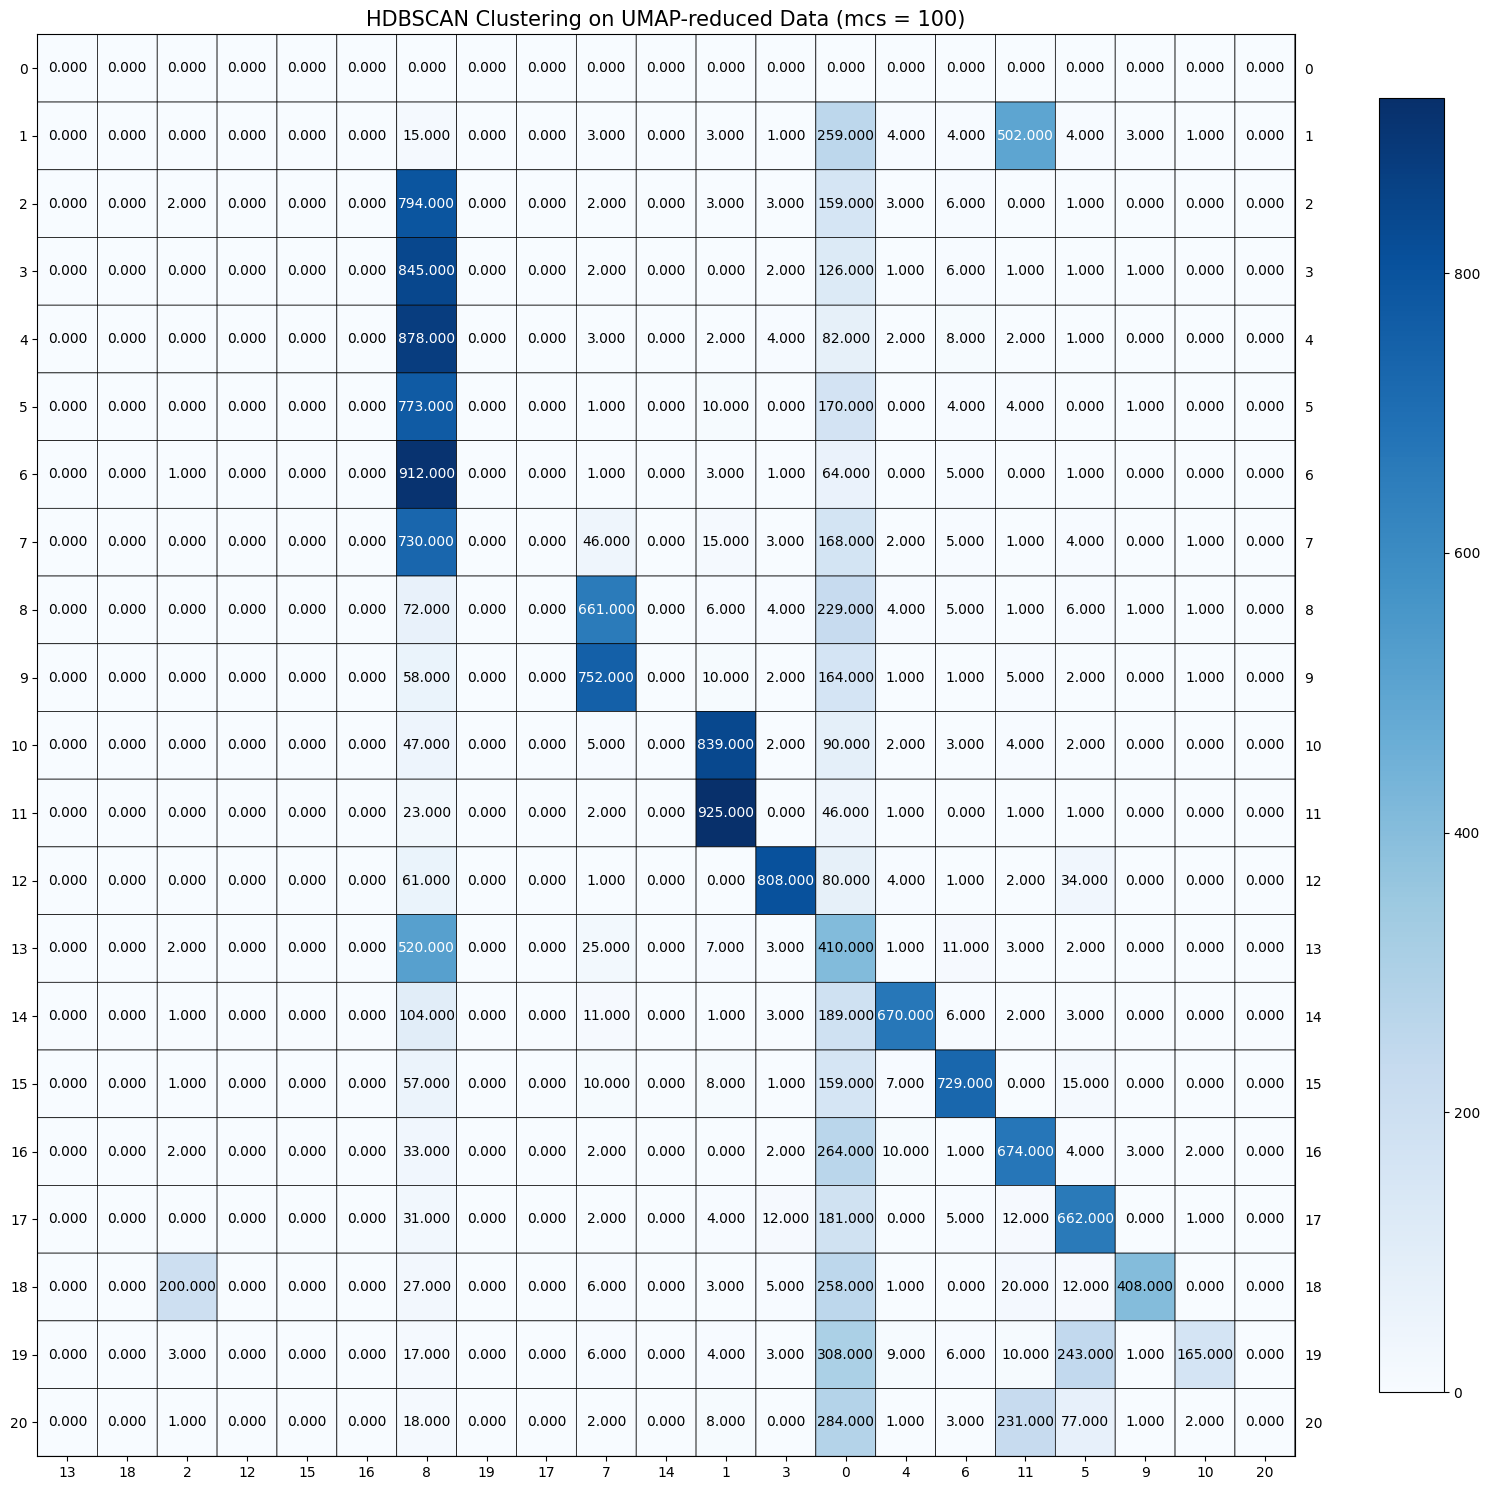

In [ ]:
########################
# HDBSCAN RESULTS
########################

for i, mcs in enumerate(min_cluster_sizes):
  print (f"Homogeneity Score (HDBSCAN, {mcs} min_cluster_size): {homogeneity_scores_HDBSCAN[i]}")
  print (f"Completeness Score (HDBSCAN, {mcs} min_cluster_size): {completeness_scores_HDBSCAN[i]}")
  print (f"V-Measure Score (HDBSCAN, {mcs} min_cluster_size): {v_measure_scores_HDBSCAN[i]}")
  print (f"Adjusted Rand Score (HDBSCAN, {mcs} min_cluster_size): {adjusted_rand_scores_HDBSCAN[i]}")
  print (f"Adjusted Mutual Info Score (HDBSCAN, {mcs} min_cluster_size): {adjusted_mutual_info_scores_HDBSCAN[i]}")
  print (f"Average Score (HDBSCAN, {mcs} min_cluster_size): {average_scores_HDBSCAN[i]}")

highest_score_HDBSCAN = max(average_scores_HDBSCAN)
best_mcs_idx = average_scores_HDBSCAN.index(highest_score_HDBSCAN)
best_mcs = min_cluster_sizes[best_mcs_idx]

cm = confusion_matrix(newsgroups.target, y_preds_HDBSCAN[best_mcs_idx])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title=f"HDBSCAN Clustering on UMAP-reduced Data (mcs = {best_mcs})", size=(15, 15))


# Deep Learning and Clustering of Image Data

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

nz = np.count_nonzero(f_all)
total = f_all.size
prop = nz / total

print(f"Proportion of Non-Zero Elements: {prop:.3f}")

(3670, 4096) (3670,)
Proportion of Non-Zero Elements: 1.000


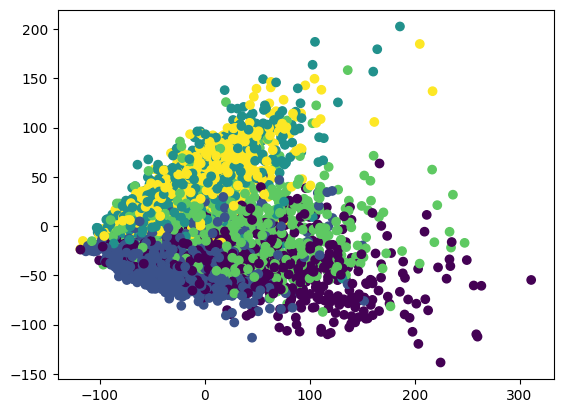

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

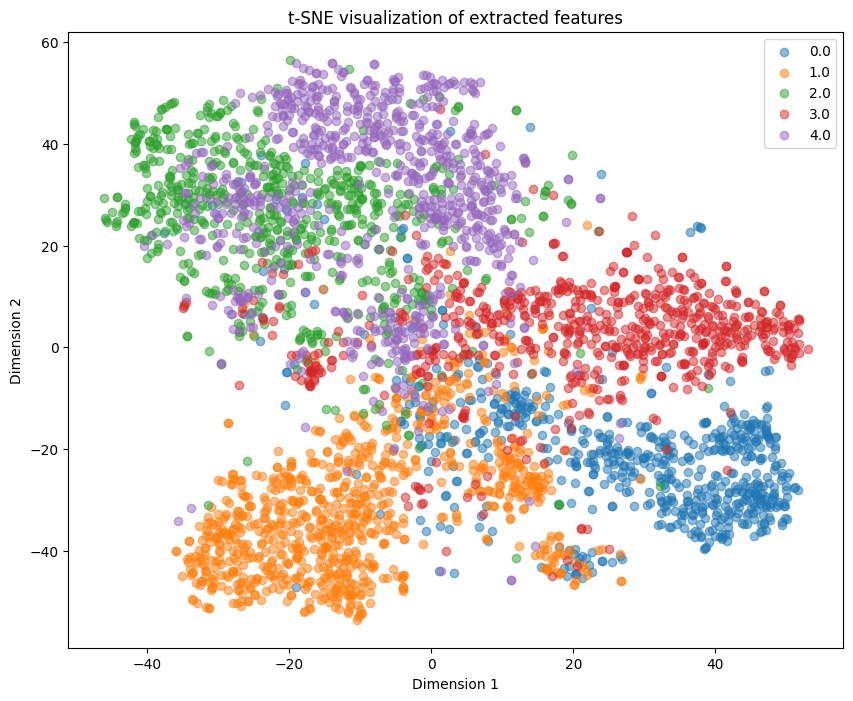

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

file = np.load('./flowers_features_and_labels.npz')
f_all, y_all = file['f_all'], file['y_all']

tsne = TSNE(n_components=2, random_state=42)
f_all_2d = tsne.fit_transform(f_all)

plt.figure(figsize=(10, 8))
for label in np.unique(y_all):
    plt.scatter(f_all_2d[y_all == label, 0], f_all_2d[y_all == label, 1], label=label, alpha=0.5)

plt.title('t-SNE visualization of extracted features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import rand_score
from sklearn.cluster import KMeans

#SVD

svd = TruncatedSVD(n_components=50)
f_all_reduced = svd.fit_transform(f_all)

kmeans = KMeans(n_clusters=5, random_state=0).fit(f_all_reduced)
predicted_labels = kmeans.labels_
score = rand_score(y_all, predicted_labels)

print("Rand Score SVD + k-means:", score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Rand Score SVD + k-means: 0.7029135038911329


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
predicted_labels_agg = agglomerative_clustering.fit_predict(f_all_reduced)
score_agg = rand_score(y_all, predicted_labels_agg)

print("Rand Score SVD + Agglomerative Clustering:", score_agg)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Rand Score SVD + Agglomerative Clustering: 0.6957926452054662


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
predicted_labels_hdbscan = clusterer.fit_predict(f_all_reduced)
score_hdbscan = rand_score(y_all, predicted_labels_hdbscan)

print("Rand Score SVD + HDBSCAN:", score_hdbscan)

Rand Score SVD + HDBSCAN: 0.4129367266656418


In [ ]:
#UMAP
import umap.umap_ as umap  # Ensure you have UMAP installed

umap_reducer = umap.UMAP(n_components=50, random_state=42)
f_all_reduced_umap = umap_reducer.fit_transform(f_all)

kmeans_umap = KMeans(n_clusters=5, random_state=42)
predicted_labels_umap = kmeans_umap.fit_predict(f_all_reduced_umap)

score_umap = rand_score(y_all, predicted_labels_umap)

print("Rand Score UMAP + K-means:", score_umap)

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
predicted_labels_agg = agglomerative_clustering.fit_predict(f_all_reduced_umap)
score_agg = rand_score(y_all, predicted_labels_agg)

print("Rand Score UMAP + Agglomerative Clustering:", score_agg)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
predicted_labels_hdbscan = clusterer.fit_predict(f_all_reduced_umap)
score_hdbscan = rand_score(y_all, predicted_labels_hdbscan)

print("Rand Score UMAP + HDBSCAN:", score_hdbscan)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Rand Score UMAP + K-means: 0.7962947532273864


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Rand Score UMAP + Agglomerative Clustering: 0.7885879409412242
Rand Score UMAP + HDBSCAN: 0.7248875808285488


In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
#AUTOENCODER

f_all_reduced_auto =Autoencoder(50).fit_transform(f_all)

kmeans_nmf = KMeans(n_clusters=5, random_state=0)
predicted_labels_nmf = kmeans_nmf.fit_predict(f_all_reduced_auto)
score_nmf = rand_score(y_all, predicted_labels_nmf)

print("Rand Score: AUTO + K-means:", score_nmf)

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
predicted_labels_agg = agglomerative_clustering.fit_predict(f_all_reduced_auto)
score_agg = rand_score(y_all, predicted_labels_agg)

print("Rand Score: AUTO + Agglomerative Clustering:", score_agg)


clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
predicted_labels_hdbscan = clusterer.fit_predict(f_all_reduced_auto)
score_hdbscan = rand_score(y_all, predicted_labels_hdbscan)

print("Rand Scor: AUTO + HDBSCAN:", score_hdbscan)

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Rand Score: AUTO + K-means: 0.7278913171182371


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Rand Score: AUTO + Agglomerative Clustering: 0.7498346482013304
Rand Scor: AUTO + HDBSCAN: 0.46646303108079107


In [ ]:
# MLP CLASSIFIER

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            running_loss = 0.0
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                outputs = self.model(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            # print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
        return self

    def eval(self, X_test, y_test):
      X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
      y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

      self.model.eval()

      correct = 0
      total = 0
      with torch.no_grad():
          outputs = self.model(X_test)
          _, predicted = torch.max(outputs, 1)
          total += y_test.size(0)
          correct += (predicted == y_test).sum().item()
      print('Accuracy: %d %%' % (
        100 * correct / total))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

mlp = MLP(4096)
mlp.train(X_train, y_train)

mlp.eval(X_test, y_test)

100%|██████████| 100/100 [00:10<00:00,  9.58it/s]

Accuracy: 90 %


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_all_reduced_auto, y_all, test_size=0.2, random_state=42)

mlp = MLP(50)
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(f_all_reduced_umap, y_all, test_size=0.2, random_state=42)
mlp = MLP(50)
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(f_all_reduced, y_all, test_size=0.2, random_state=42)
mlp = MLP(50)
mlp.train(X_train, y_train)
mlp.eval(X_test, y_test)


100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Accuracy: 88 %


100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Accuracy: 84 %


100%|██████████| 100/100 [00:06<00:00, 15.56it/s]

Accuracy: 89 %


# Clustering using both image and text

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

In [ ]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [ ]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
from google.colab import drive
import os
drive.mount("/content/drive")
# os.chdir("/content/drive/MyDrive/courses/masters/winter 24/ece 219/project 2")
os.chdir("/content/drive/MyDrive/ece 219/project 2/")


def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    first_col_len = len(pokedex)

    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

Mounted at /content/drive


In [ ]:
import torch
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import clip
import matplotlib.pyplot as plt

def compute_image_embeddings(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings.append(image_embedding)

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

pokedex = construct_pokedex()

model, preprocess, device = load_clip_model()

image_embeddings = compute_image_embeddings(model, preprocess, pokedex['image_path'], device)

queries = {
    "Bug": "type: Bug",
    "Fire": "type: Fire",
    "Grass": "type: Grass",
    "Dragon": "type: Dragon",
    "Dark": "type: Dark"

}

results = {}
for type_, query in queries.items():
    text_embeddings = clip_inference_text(model, preprocess, [query], device)
    similarity = compute_similarity_image_to_text(image_embeddings.squeeze(), text_embeddings.squeeze())
    top_indices = similarity.argsort()[-5:][::-1]
    top_pokemon = pokedex.iloc[top_indices]
    results[type_] = top_pokemon

100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 114MiB/s]


  0%|          | 0/137 [00:00<?, ?it/s]

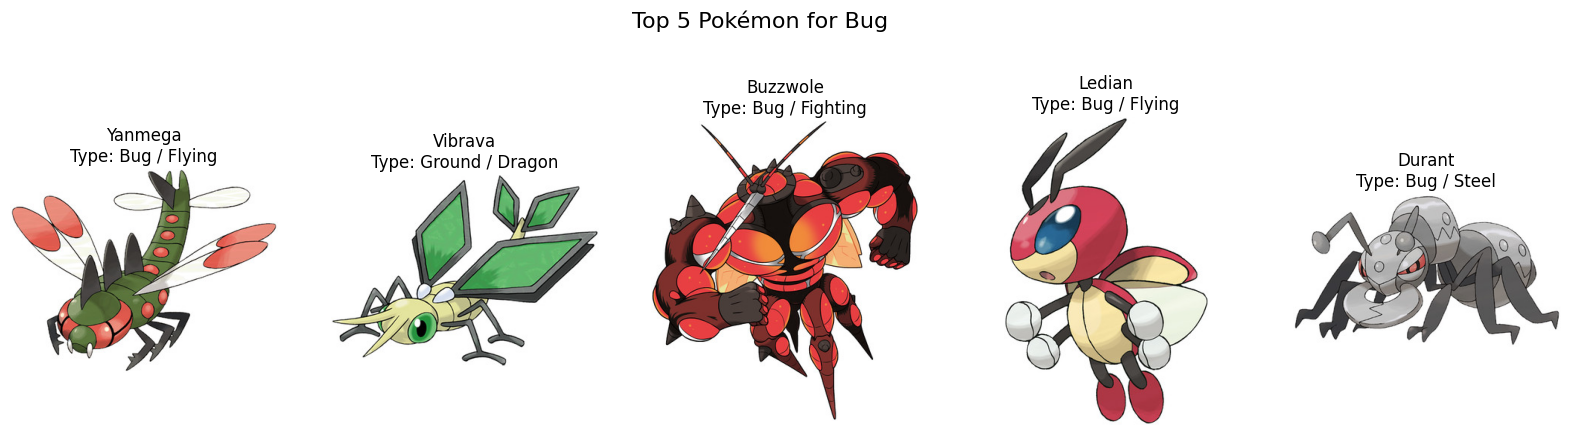

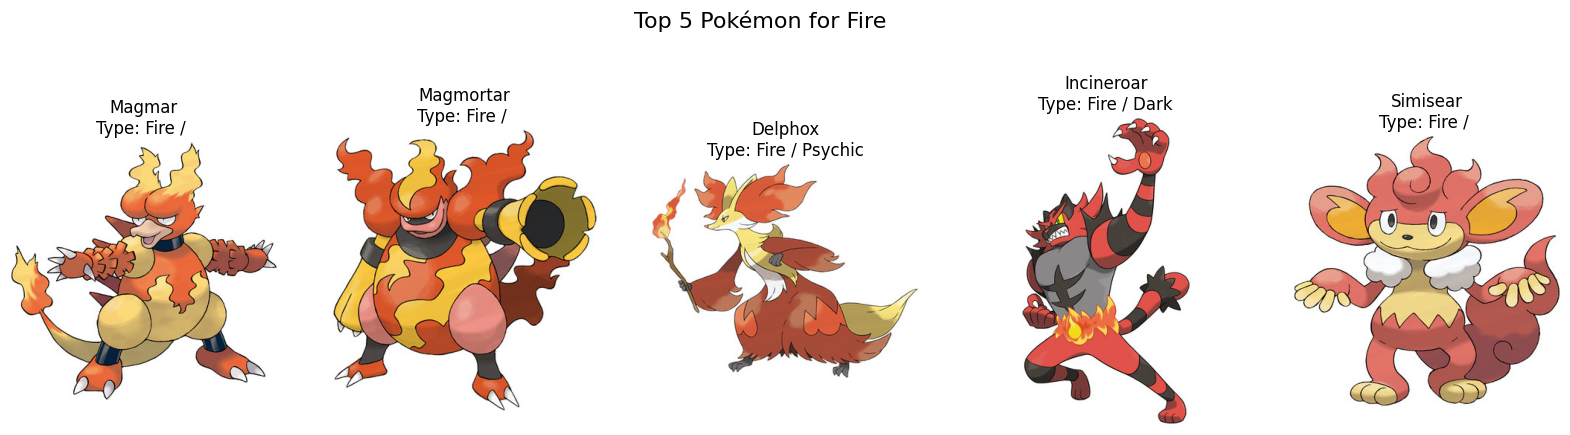

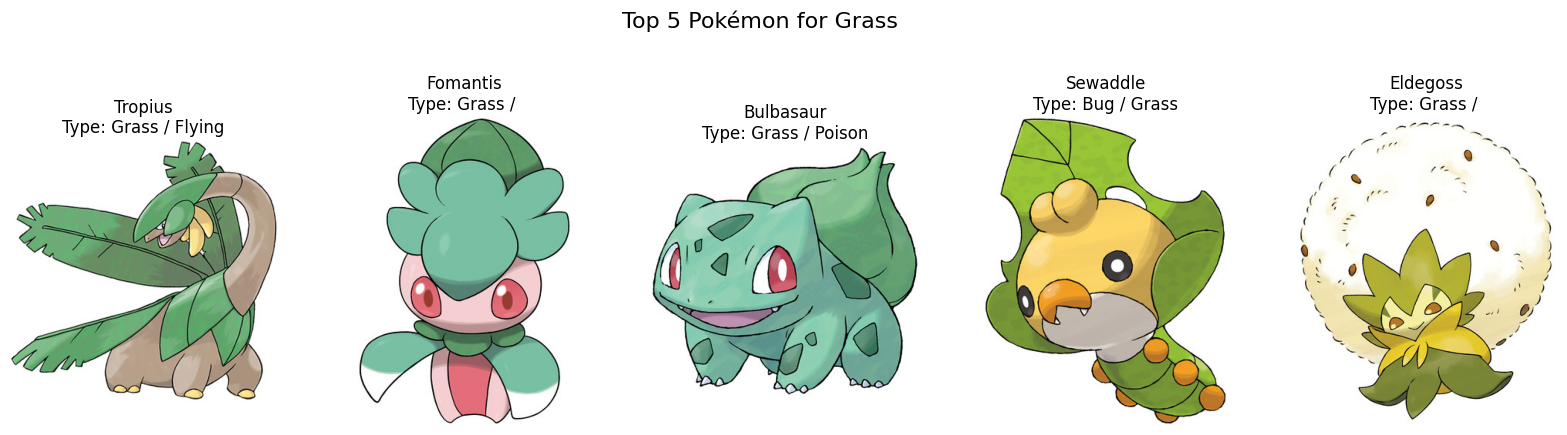

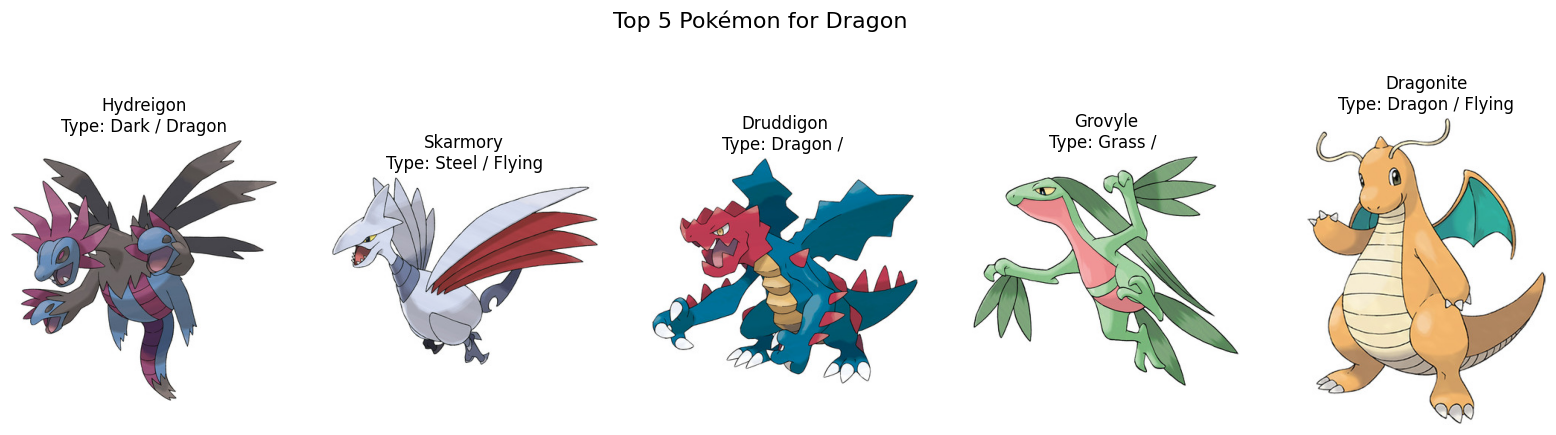

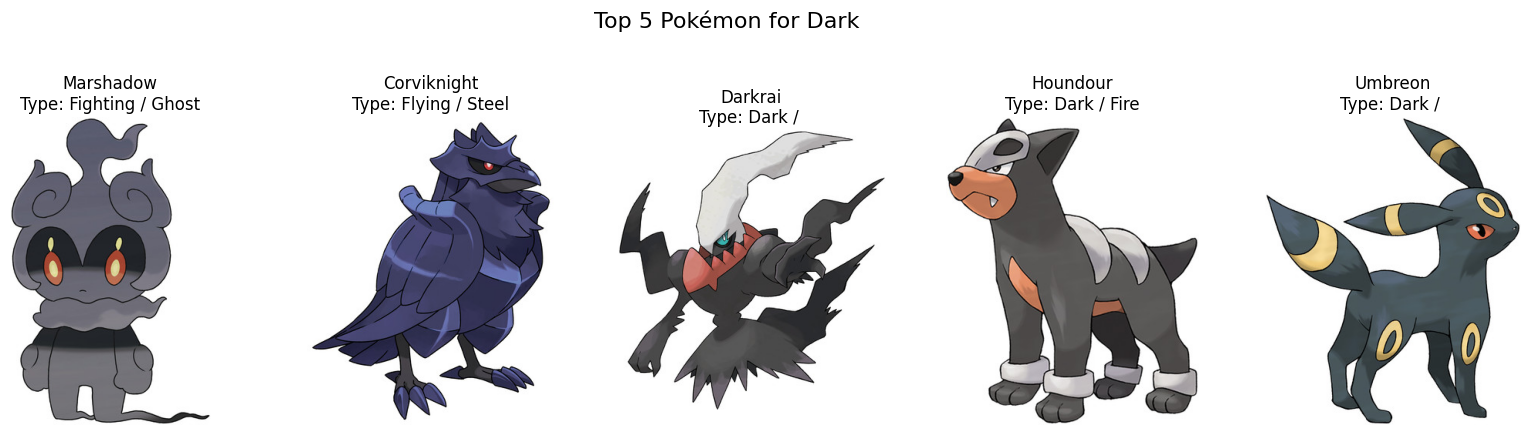

In [ ]:
for type_, pokemon_data in results.items():
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f"Top 5 Pokemon for {type_}", fontsize=16, y=1.15)  # Adjusting y value to add padding below subtitle
    for i, (_, pokemon) in enumerate(pokemon_data.iterrows()):
        img = Image.open(pokemon['image_path'])
        axes[i].imshow(img)
        axes[i].set_title(f"{pokemon['Name']}\nType: {pokemon['Type1']} / {pokemon['Type2']}")
        axes[i].axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

selected_pokemon = pokedex.sample(n=10, random_state=42)

model, preprocess, device = load_clip_model()

image_embeddings = clip_inference_image(model, preprocess, selected_pokemon["image_path"], device)

all_types = pokedex["Type1"].unique()
type_embeddings = clip_inference_text(model, preprocess, all_types, device)

similarity_image_to_type = compute_similarity_image_to_text(image_embeddings, type_embeddings)

top_types_indices = np.argsort(similarity_image_to_type, axis=1)[:, -5:]
top_types = all_types[top_types_indices]
top_probs = np.take_along_axis(similarity_image_to_type, top_types_indices, axis=1)


  0%|          | 0/10 [00:00<?, ?it/s]

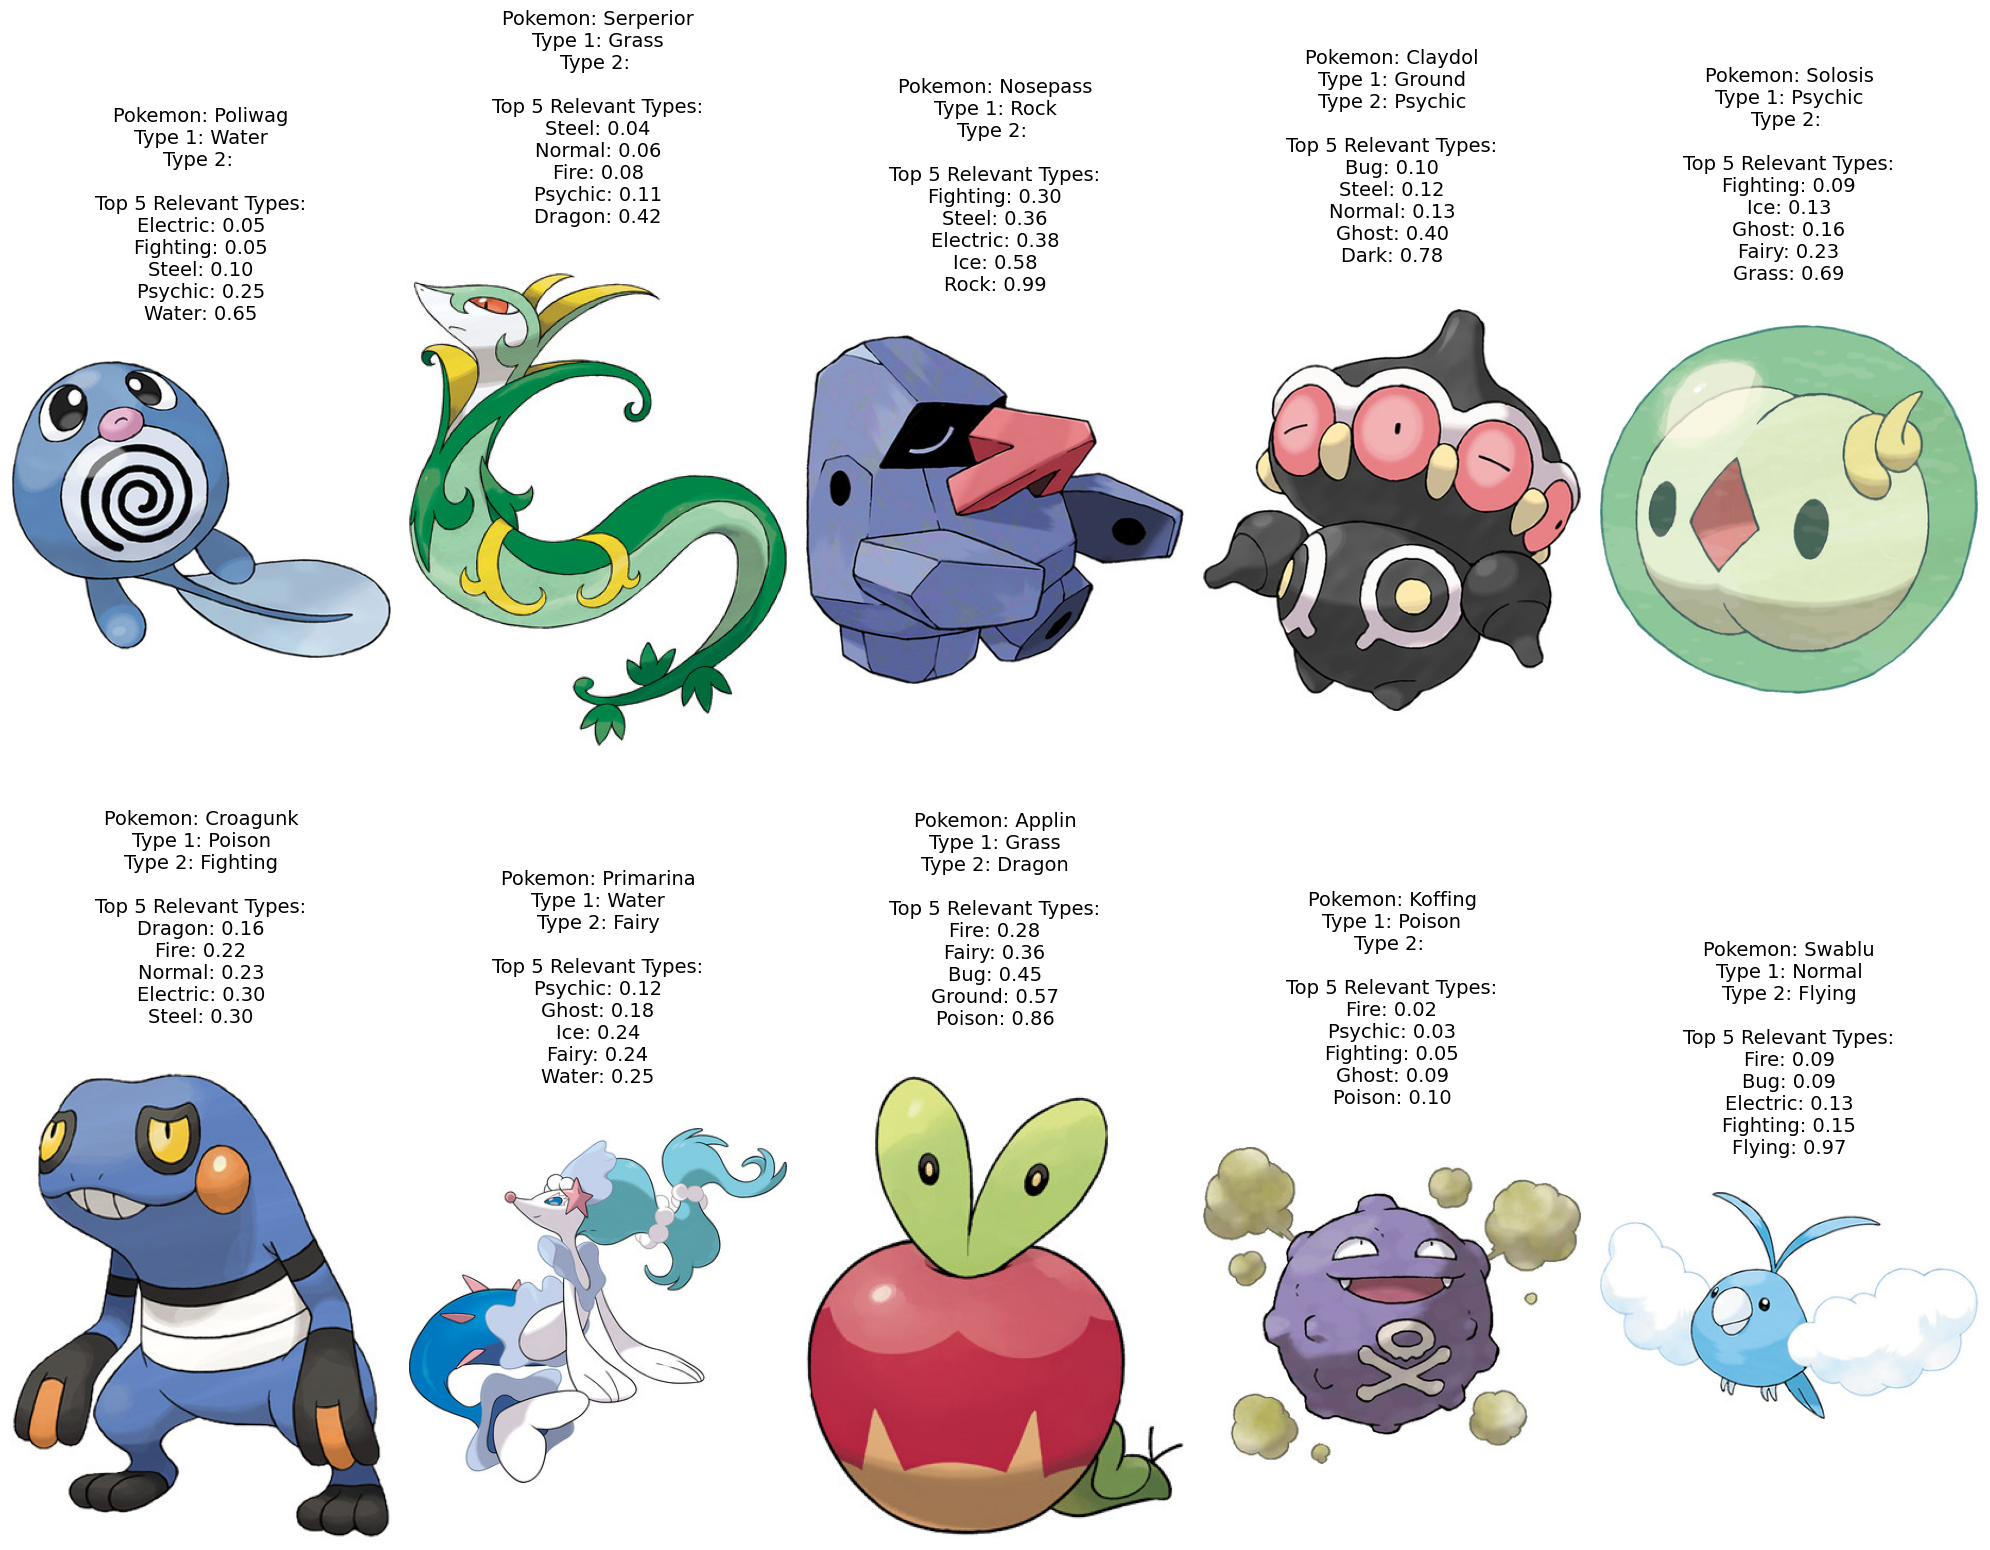

In [ ]:
def plot_pokemon(pokemon_name, type1, type2, image_path, top_types, top_probs, ax):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')

    text = f"Pokemon: {pokemon_name}\nType 1: {type1}\nType 2: {type2}\n\nTop 5 Relevant Types:\n"
    for type_, prob in zip(top_types, top_probs):
        text += f"{type_}: {prob:.2f}\n"
    ax.text(0.5, 1.05, text, fontsize=14, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)


fig, axes = plt.subplots(2, 5, figsize=(20, 18))

for i, (pokemon, ax) in enumerate(zip(selected_pokemon.iterrows(), axes.flatten())):
  plot_pokemon(pokemon[1]["Name"], pokemon[1]["Type1"], pokemon[1]["Type2"], pokemon[1]["image_path"],
                top_types[i], top_probs[i], ax)


plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE

def filter_pokemon_by_type(pokedex, type_name):
    return pokedex[(pokedex['Type1'] == type_name) | (pokedex['Type2'] == type_name)]

types = ['Bug', 'Fire', 'Grass']
filtered_pokemon = pd.concat([filter_pokemon_by_type(pokedex, t) for t in types])

filtered_pokemon.reset_index(drop=True, inplace=True)
model, preprocess, device = load_clip_model()
image_embeddings = clip_inference_image(model, preprocess, filtered_pokemon["image_path"], device)

tsne_embeddings = TSNE(n_components=2, random_state=42).fit_transform(image_embeddings)

tsne_df = pd.DataFrame(tsne_embeddings, columns=['TSNE1', 'TSNE2'])
tsne_df['Name'] = filtered_pokemon['Name']
tsne_df['Type1'] = filtered_pokemon['Type1']

fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='Type1', hover_name='Name')

In [ ]:
fig.show()